In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import example_code
from example_code import get_data_yaml_dict_times
from example_code import draw_speed_graphs
import re
from statsmodels.tsa.seasonal import STL

In [179]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

In [3]:
def get_dataframe(target="mean cwnd", goodness_tresh=10000, experiments_max=3):
    '''Settings'''
    algos = ["BBR2"] # Анализируемые алгоритмы управления перегрузкой
    with_averaging = False
    #goodness_tresh - Минимальная удобоваримая длительность эксперимента, а также сколько секунд мы анализируем
    #experiments_max - Максимумальное количество анализируемых экспериментов
    paths_yaml = ["long_experiments/perfres_w3_long_experiments_fec_dummy"] # Директория с экспериментами
    path_savexlsxs = "~/" # Куда сохранять excel

    '''Parse data'''
    data_dict, data_dict_key_semantics = get_data_yaml_dict_times(paths_yaml, target=target,\
            experiments_max=experiments_max, goodness_tresh=goodness_tresh, with_averaging=with_averaging)

    '''Put data in excel format'''
    data_dict_key_semantics_tmp = data_dict_key_semantics + ["Runs_count"] + [f"{i}-{i+1} second."\
                                                            for i in range(goodness_tresh - 1)]
    data_list_tmp = []
    for key, value in data_dict.items():
        data_list_tmp_sample = list(key) + [data_dict[key]['runs_count']]\
            + list(data_dict[key]['speed_graph'][:(goodness_tresh - 1)])
        data_list_tmp.append(data_list_tmp_sample)
    df = pd.DataFrame(data_list_tmp, columns=data_dict_key_semantics_tmp)
    return df, data_dict, data_dict_key_semantics

def to_time_series(df, target="mean cwnd"):
    data = df.iloc[:,10:].T
    data.index = pd.date_range(start = '2023-01-01 00:00:00.000', periods = len(data), freq='D')
    data = pd.DataFrame(data).rename(columns={0 : target+"_1", 1 : target+"_2", 2 : target+"_3"})
    data = data.astype("float32")
    return data

## EM-алгоритм

## Загрузим Mean CWND и построим график.

In [262]:
df_cwnd, data_dict, data_dict_key_semantics = get_dataframe("mean cwnd")
time_series_cwnd = to_time_series(df_cwnd, "mean cwnd")

BAD!:  0
BAD!:  0
BAD!:  0


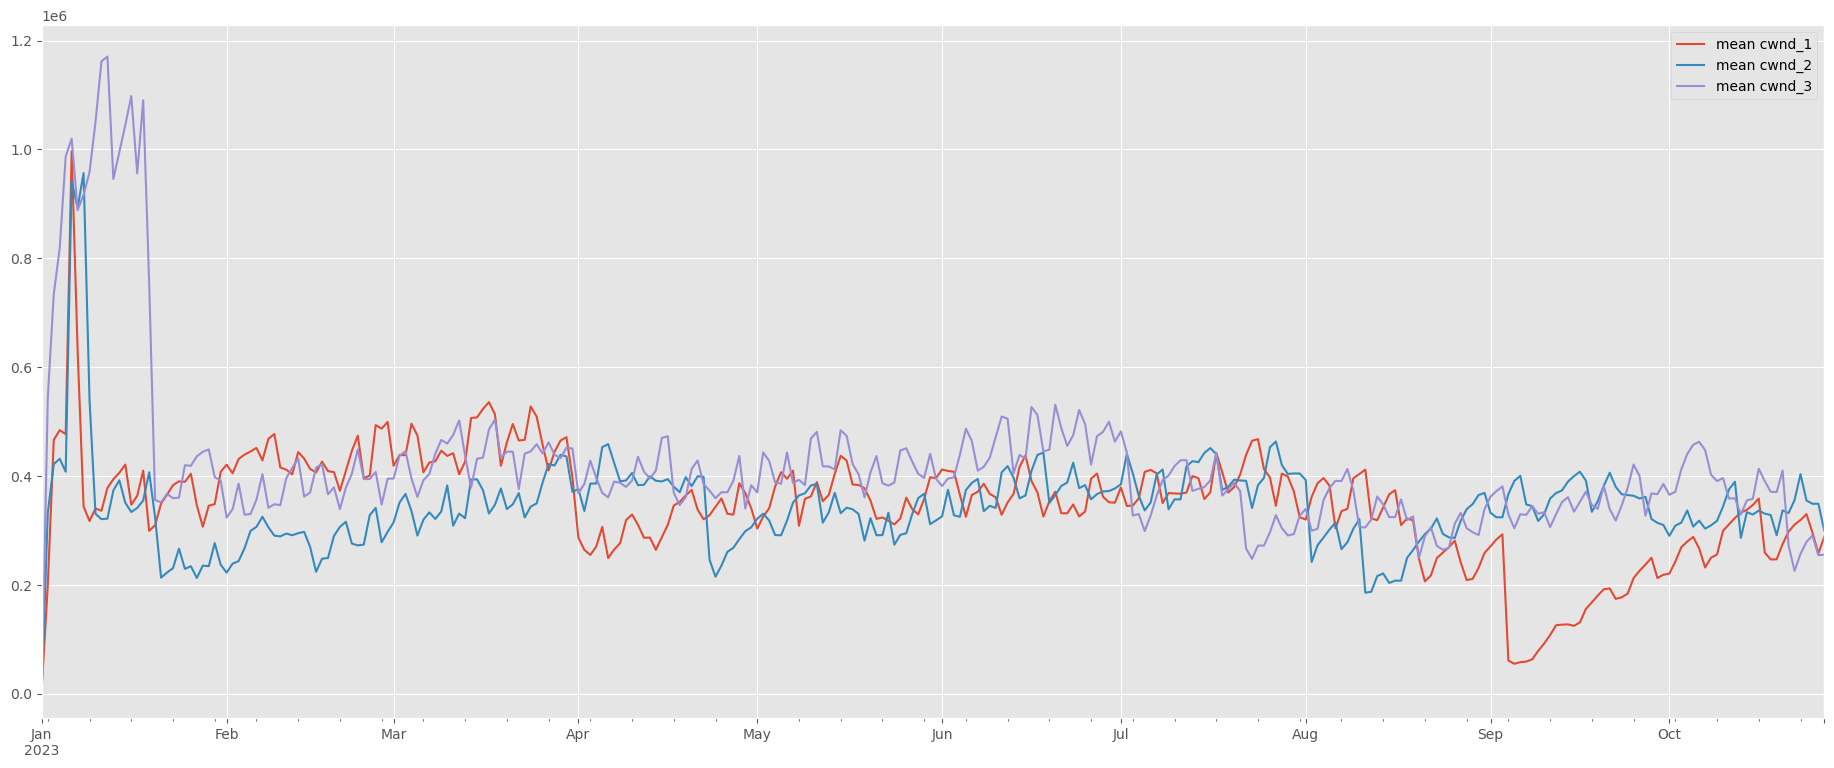

In [263]:
time_series_cwnd[:300].plot();

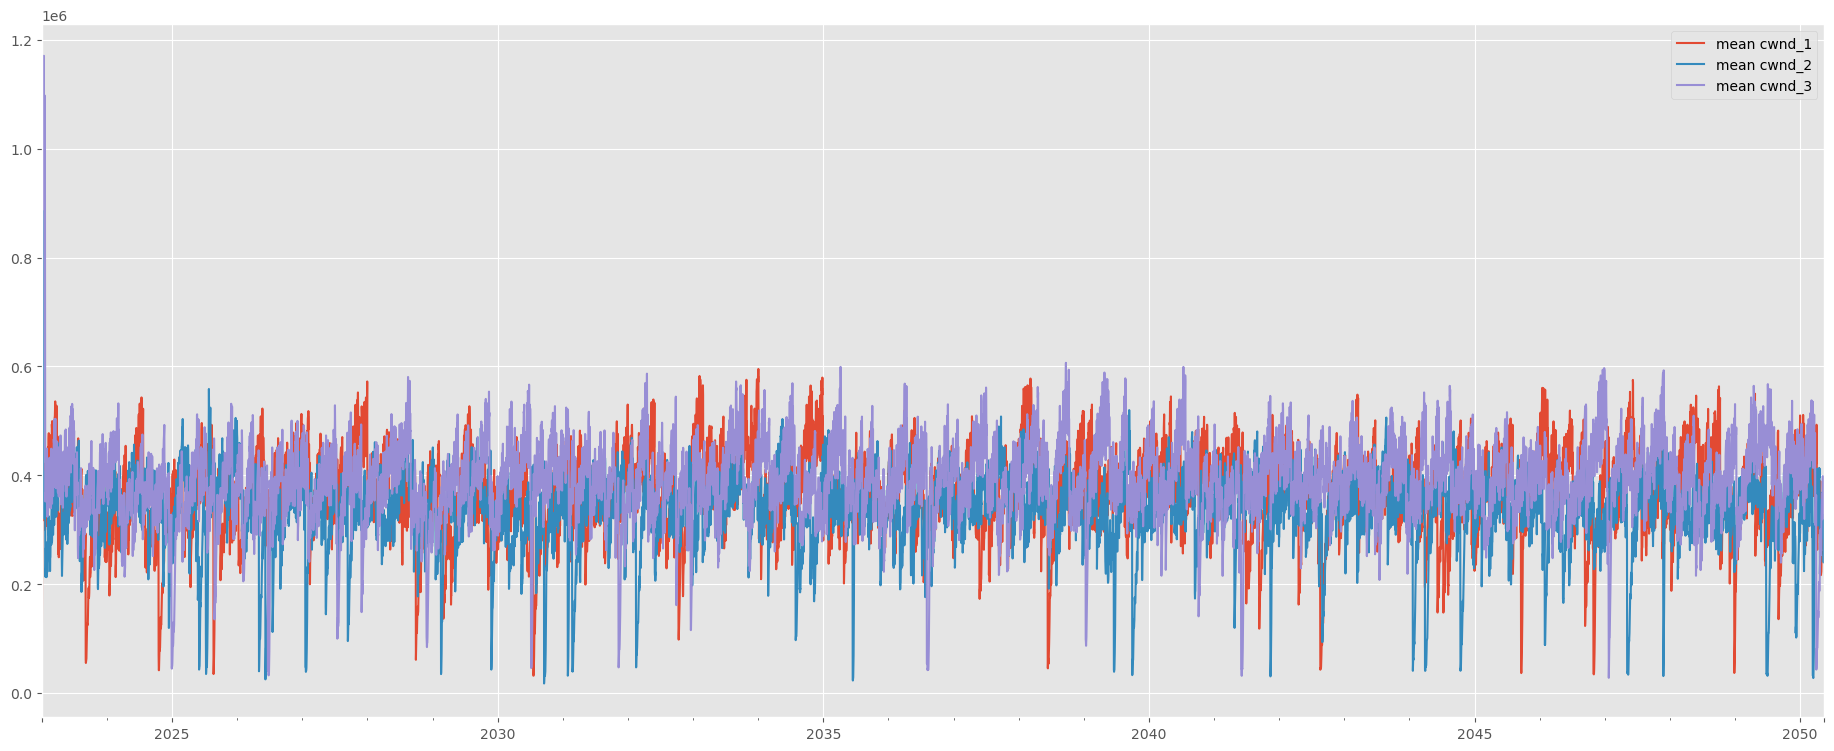

In [264]:
time_series_cwnd.plot();

## Построим распределения для каждого эксперимента.

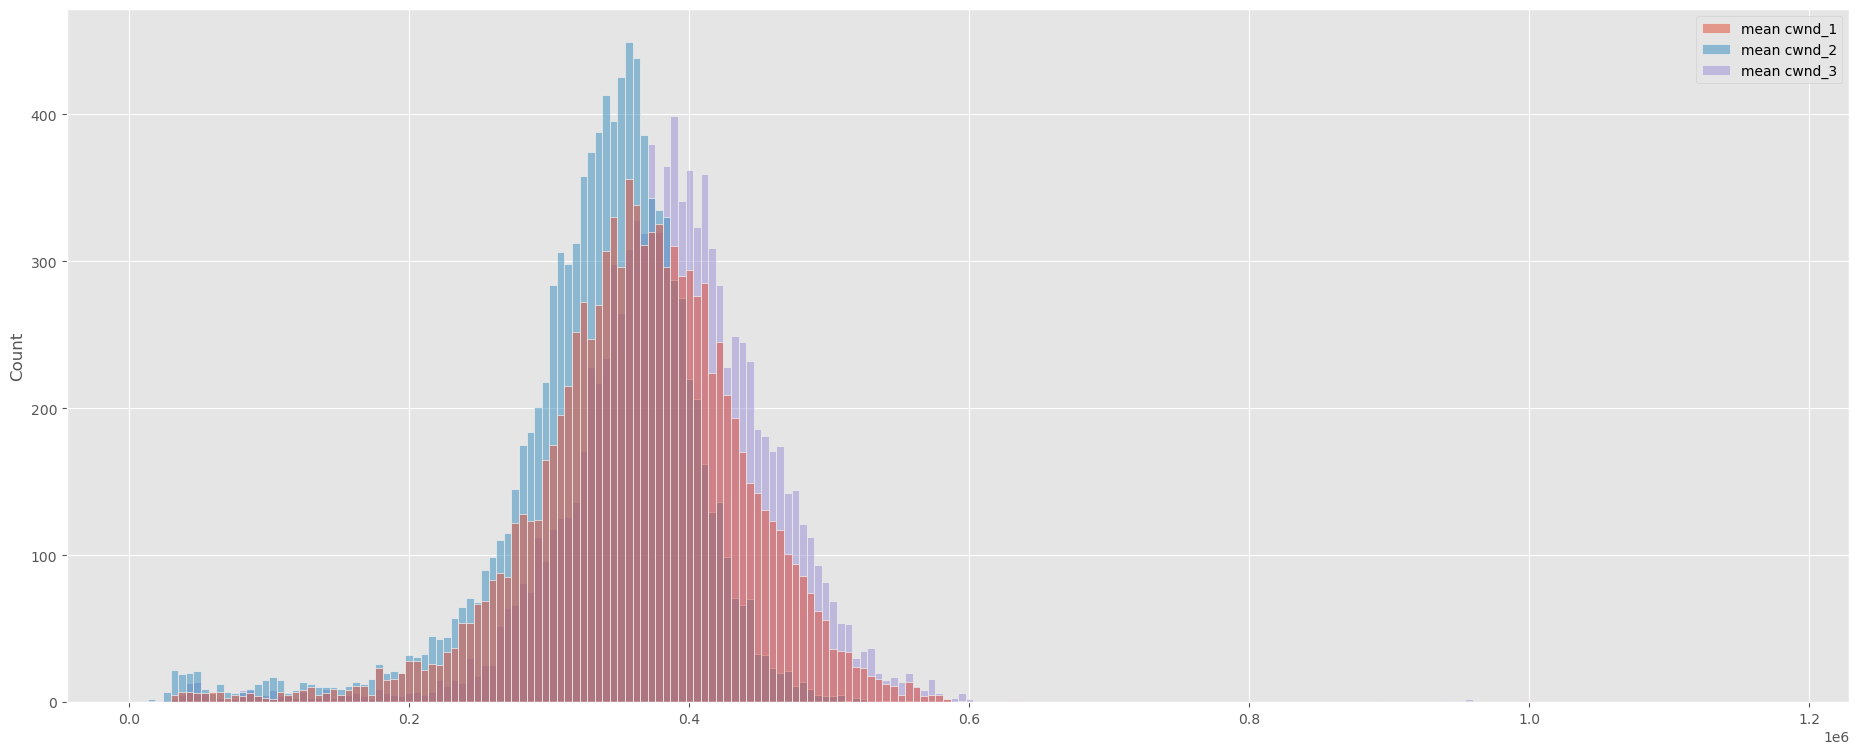

In [265]:
sns.histplot(data=time_series_cwnd, pmax=0.5);

## Видим схожесть с нормальным. Построим qq-plot и проведём тест Шапиро-Уилка.

In [266]:
from statsmodels.graphics.gofplots import qqplot
from scipy import stats

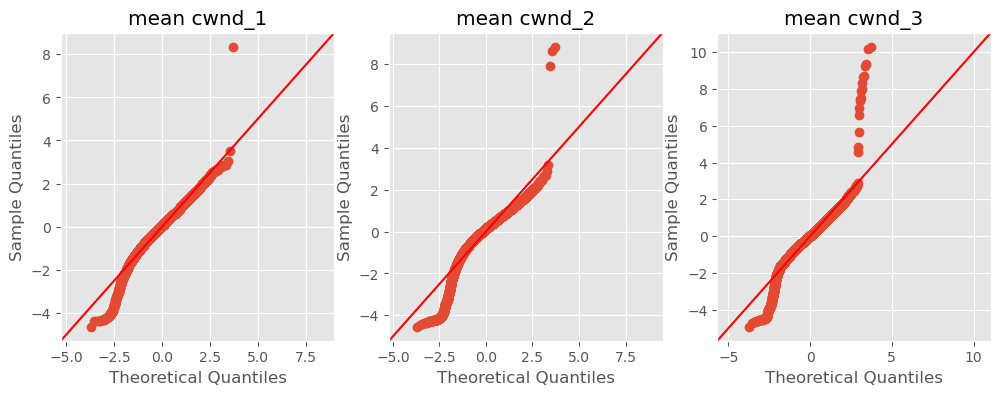

In [267]:
f, axs = plt.subplots(1,3, figsize=(12, 4))
qqplot(time_series_cwnd["mean cwnd_1"], fit=True, line="45",ax = axs[0]);
qqplot(time_series_cwnd["mean cwnd_2"], fit=True, line="45",ax = axs[1]);
qqplot(time_series_cwnd["mean cwnd_3"], fit=True, line="45",ax = axs[2]);
axs[0].title.set_text(f"mean cwnd_1")
axs[1].title.set_text(f"mean cwnd_2")
axs[2].title.set_text(f"mean cwnd_3")

In [268]:
for exp in time_series_cwnd:
    stat, pvalue = stats.shapiro(np.random.choice(time_series_cwnd[exp].values, size=1000))
    print(exp, f": {stat = }, {pvalue = }\n")

mean cwnd_1 : stat = 0.9685647487640381, pvalue = 6.963061447958288e-14

mean cwnd_2 : stat = 0.9103839993476868, pvalue = 8.316087254723048e-24

mean cwnd_3 : stat = 0.9296668171882629, pvalue = 2.962480316992612e-21



## На любом разумном уровне значимости данные противорчат гипотизе о нормальности.

## Загрузим Loss 3 и построим графики.

In [269]:
data_loss_3, data_dict, data_dict_key_semantics = get_dataframe("mean loss3")
time_series_loss_3 = to_time_series(data_loss_3, "mean loss3")

BAD!:  0
BAD!:  0
BAD!:  0


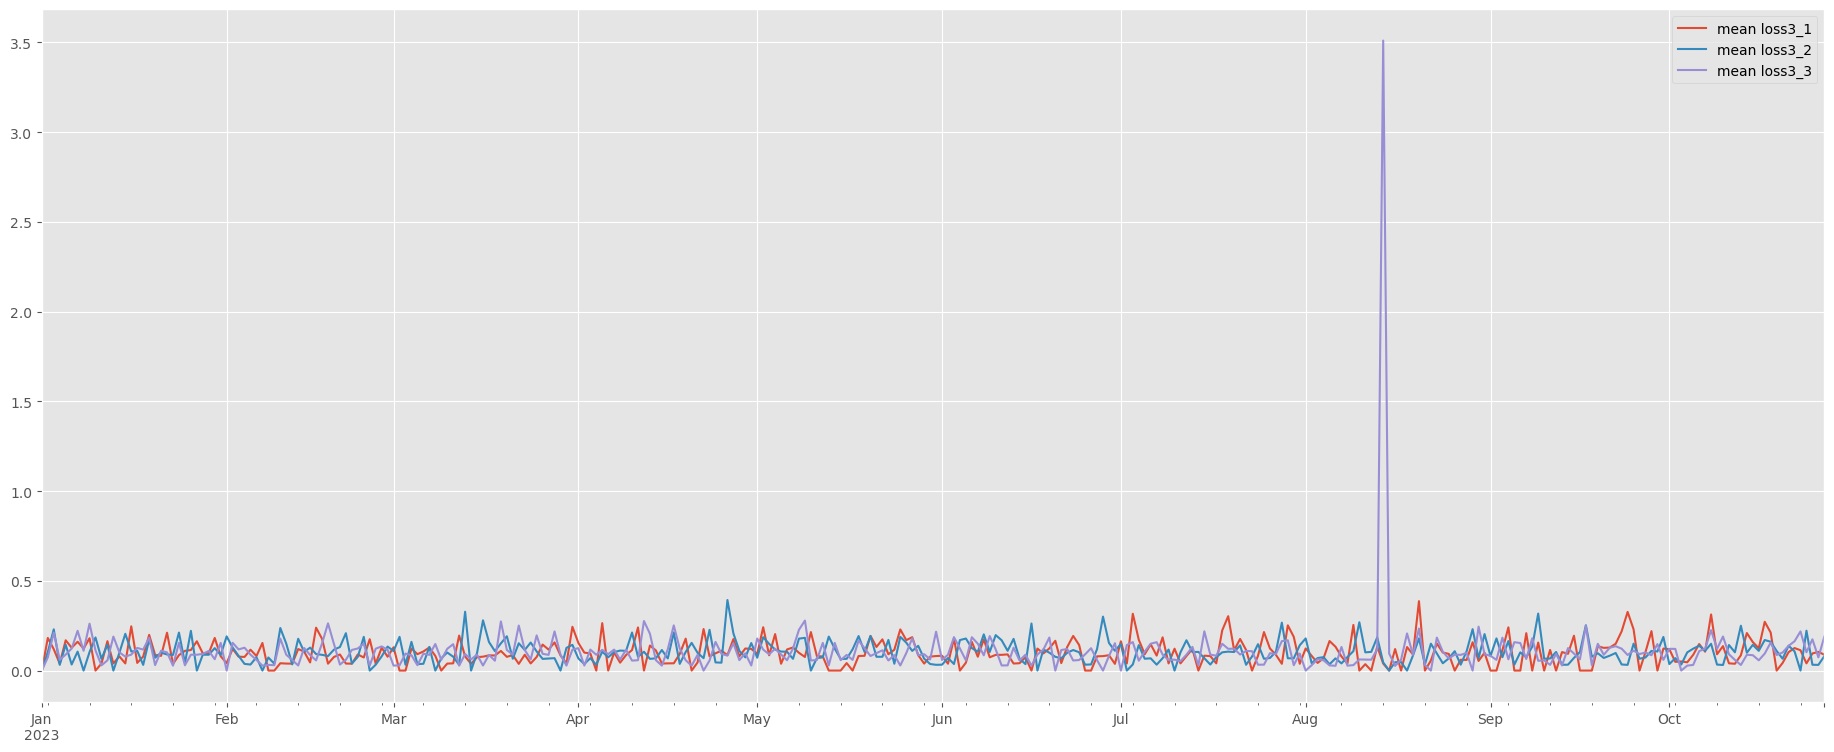

In [270]:
# Первые 300 наблюдений
time_series_loss_3[:300].plot();

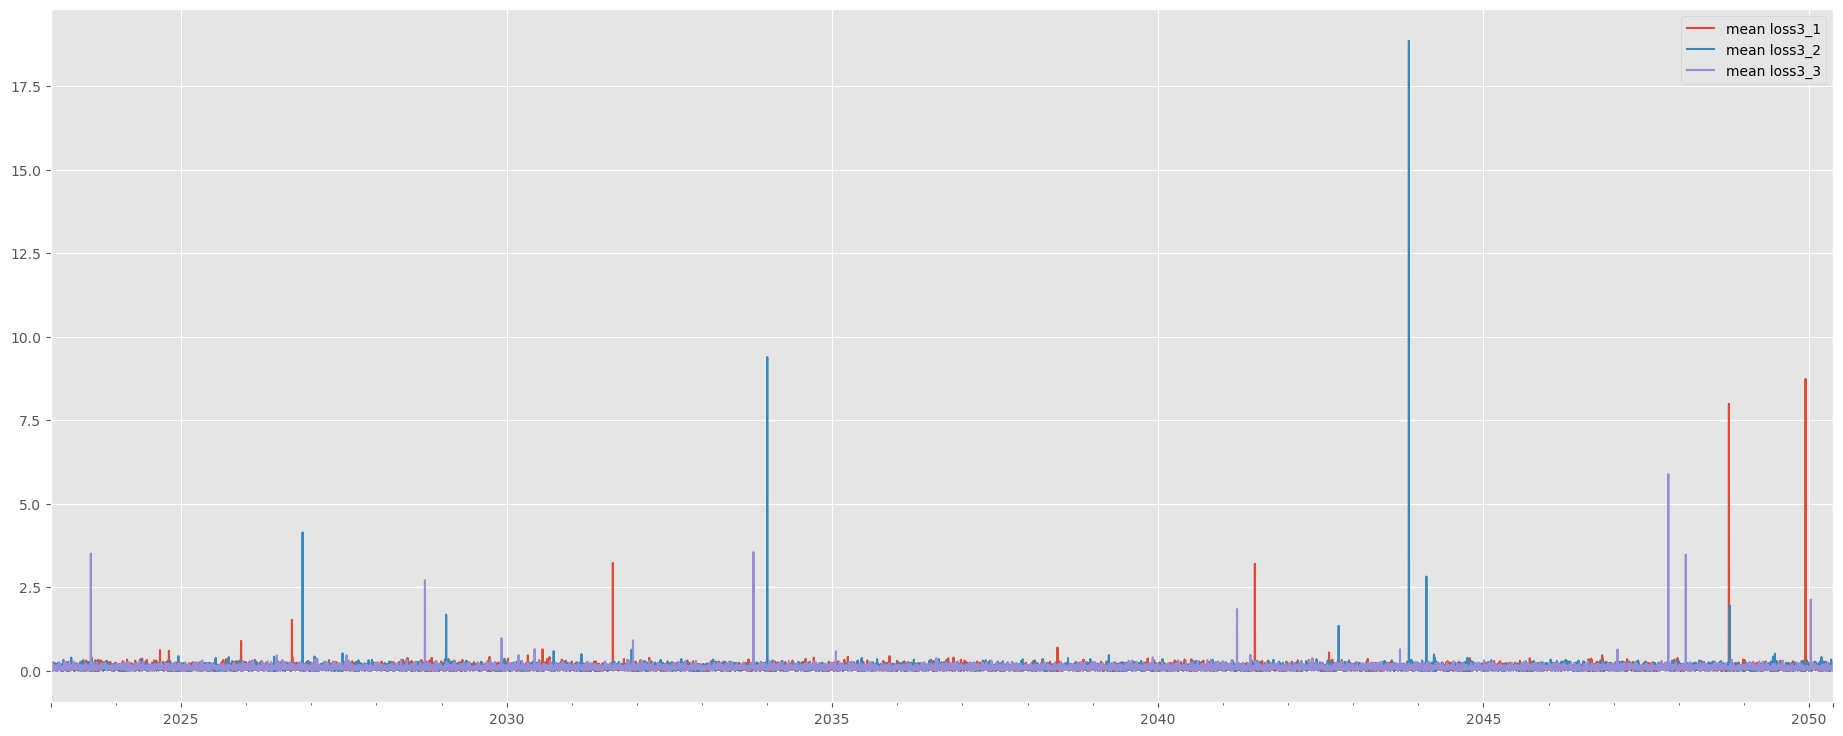

In [271]:
time_series_loss_3.plot();

## Видим выбросы. Удалим их и интерполируем ряд.

In [272]:
time_series_loss_3_smooth = time_series_loss_3.copy()
for i in range(3):
    time_series_loss_3_smooth.iloc[time_series_loss_3_smooth.iloc[:,i] >\
                                np.quantile(time_series_loss_3_smooth.iloc[:,i], 0.99), i] = np.nan
time_series_loss_3_smooth = time_series_loss_3_smooth.interpolate()

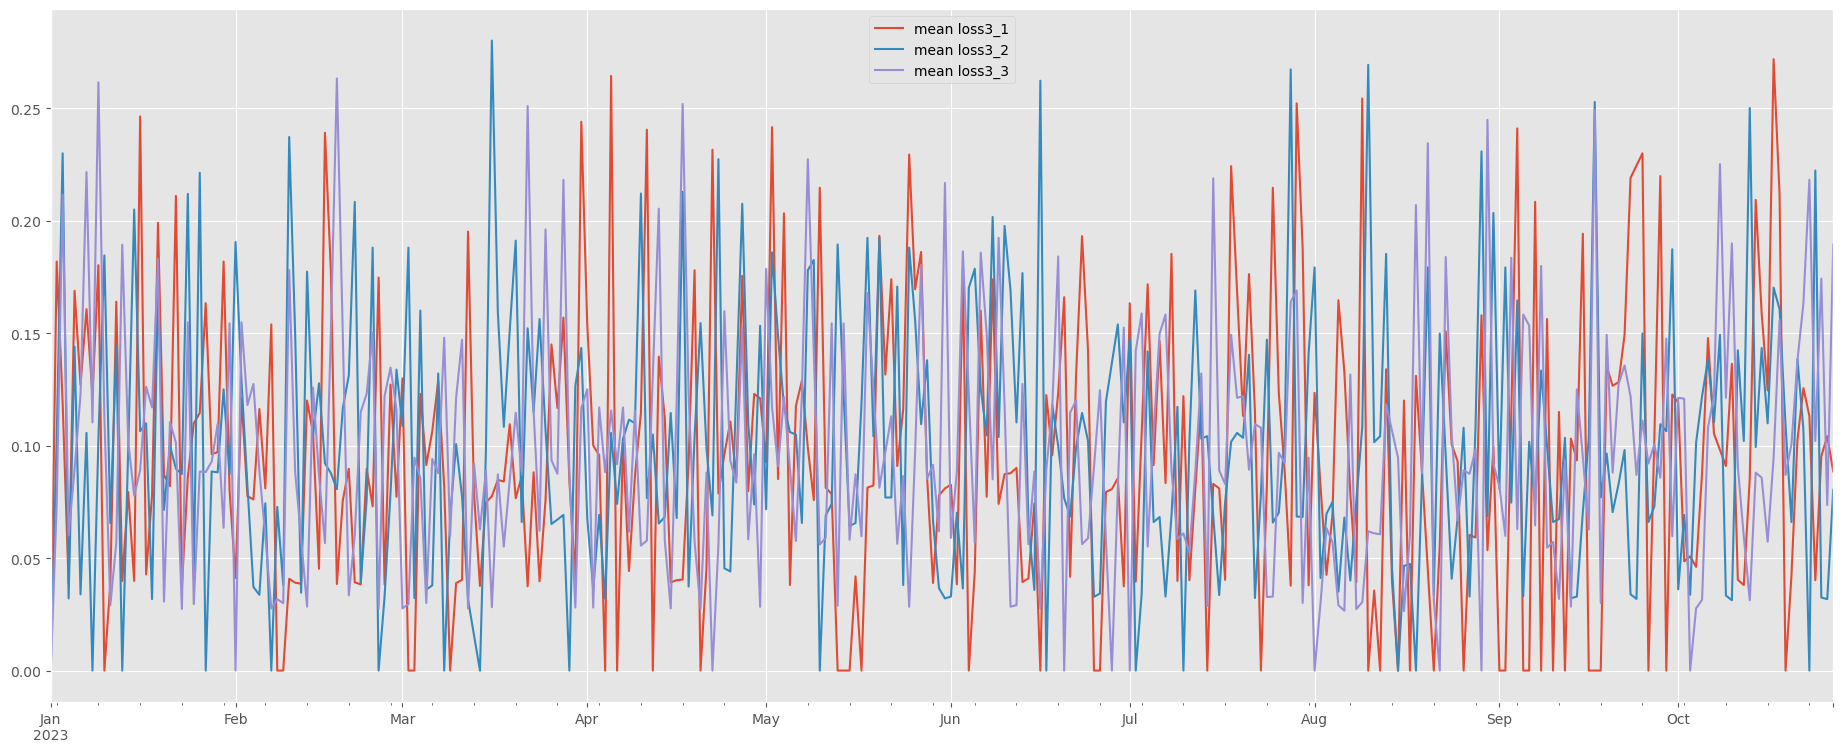

In [273]:
time_series_loss_3_smooth[:300].plot();

## Посмотрим на распределение loss3.

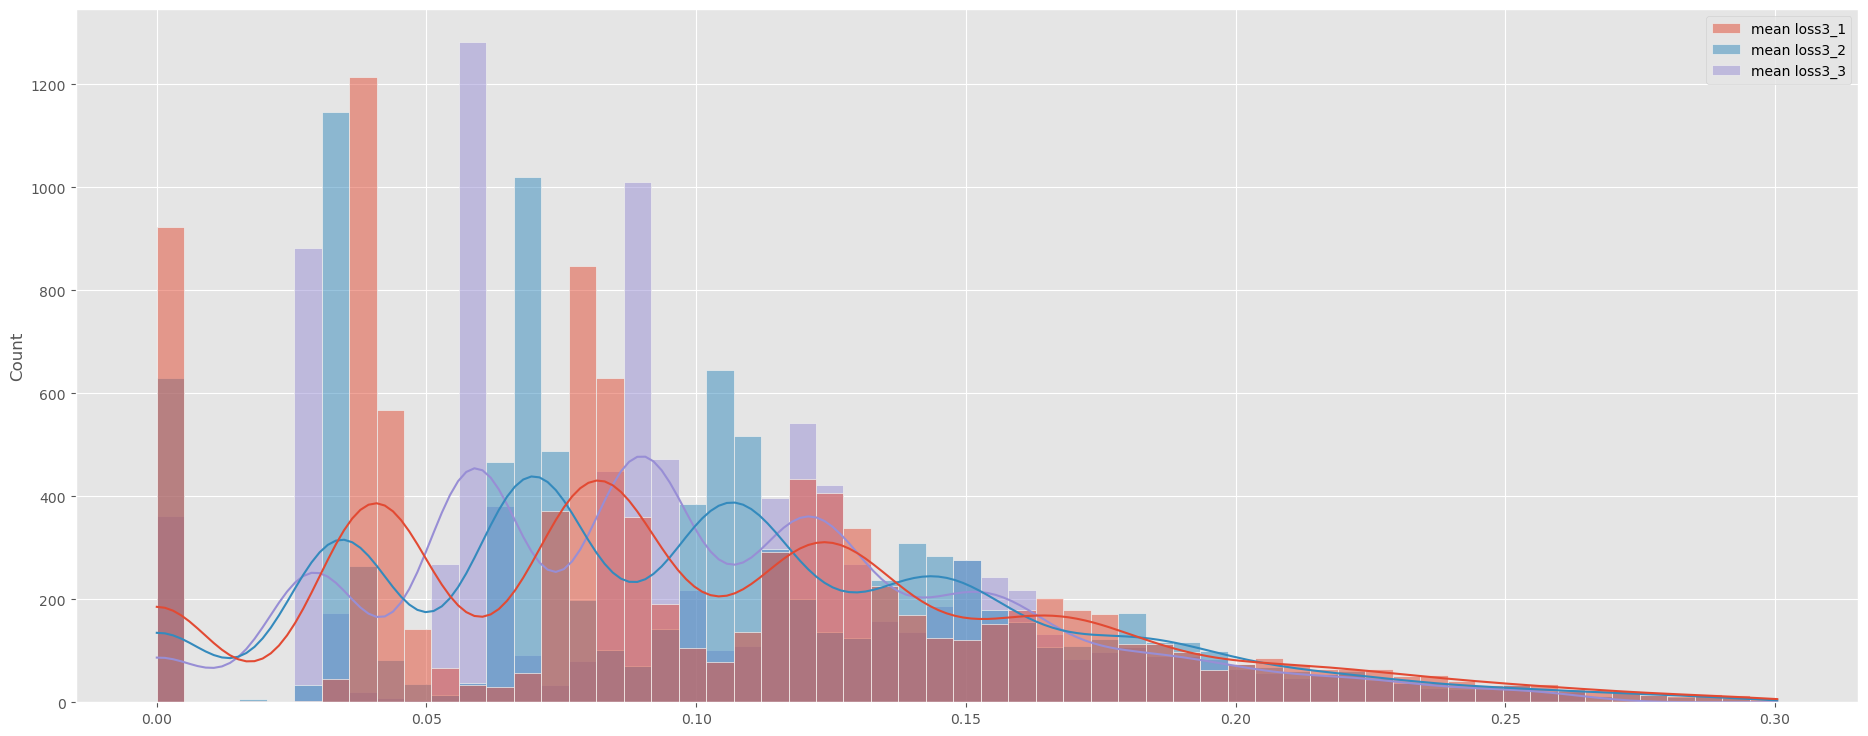

In [274]:
sns.histplot(data=time_series_loss_3_smooth, pmax=0.5, kde=True);

## Распределение таргета на первом эксперименте.

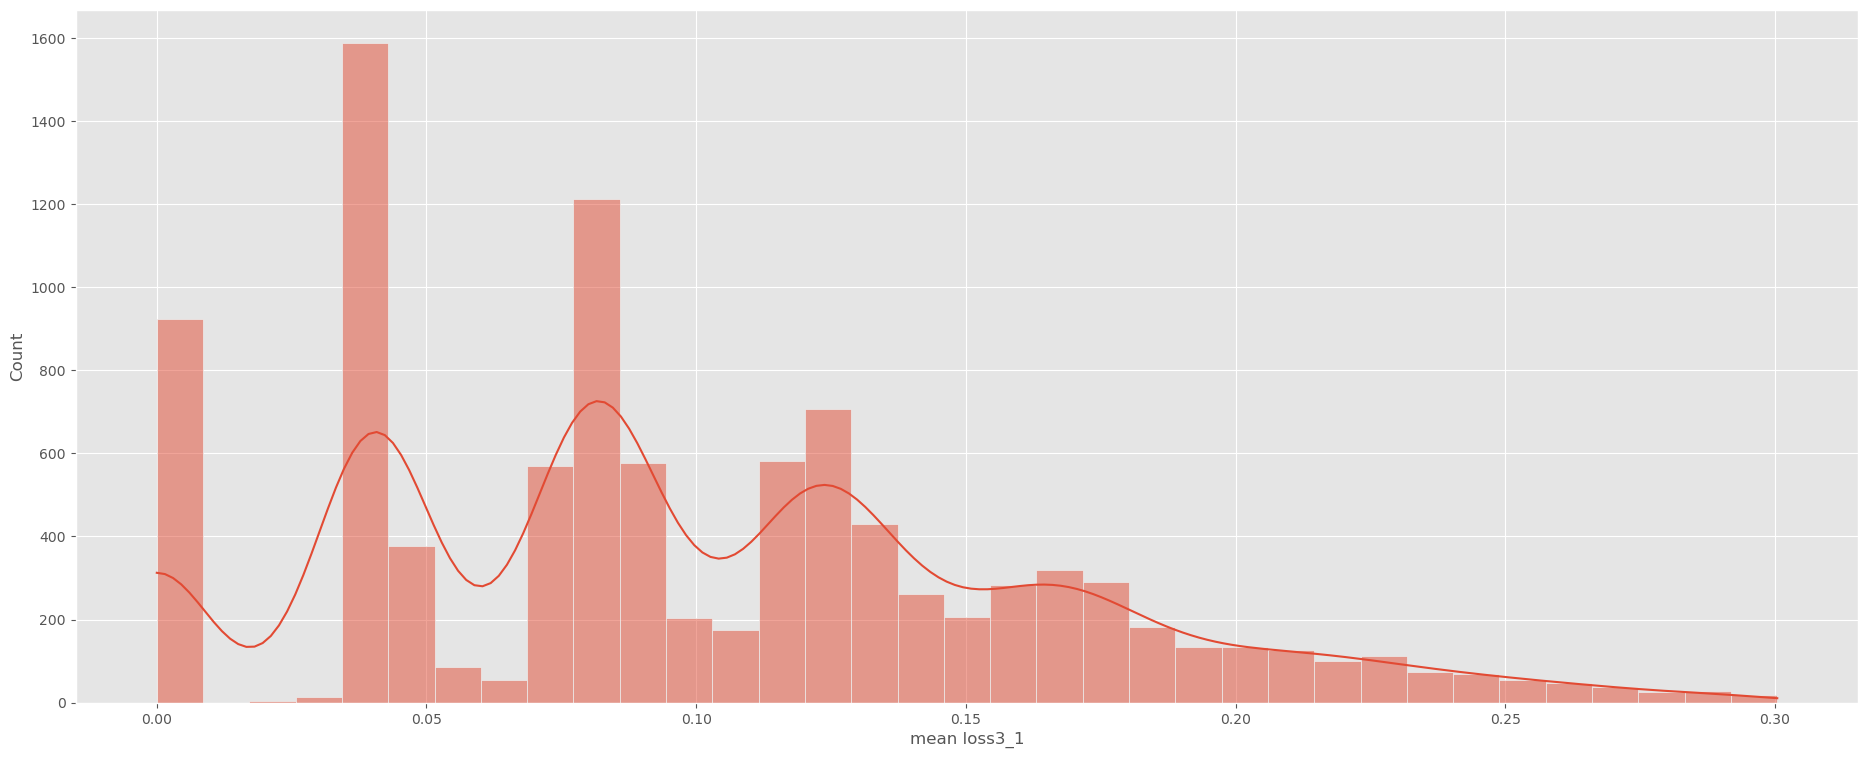

In [275]:
sns.histplot(data=time_series_loss_3_smooth["mean loss3_1"], kde=True);

## Удалим нули.

In [276]:
for i in range(3):
    time_series_loss_3_smooth.iloc[time_series_loss_3_smooth.iloc[:,i] == 0, i] = np.nan
time_series_loss_3_smooth = time_series_loss_3_smooth.interpolate()[1:]
first_exp = np.array(time_series_loss_3_smooth.iloc[:,0])
second_exp = np.array(time_series_loss_3_smooth.iloc[:,1])
third_exp = np.array(time_series_loss_3_smooth.iloc[:,2])

## Применим EM алгоритм к первому эксперименту.

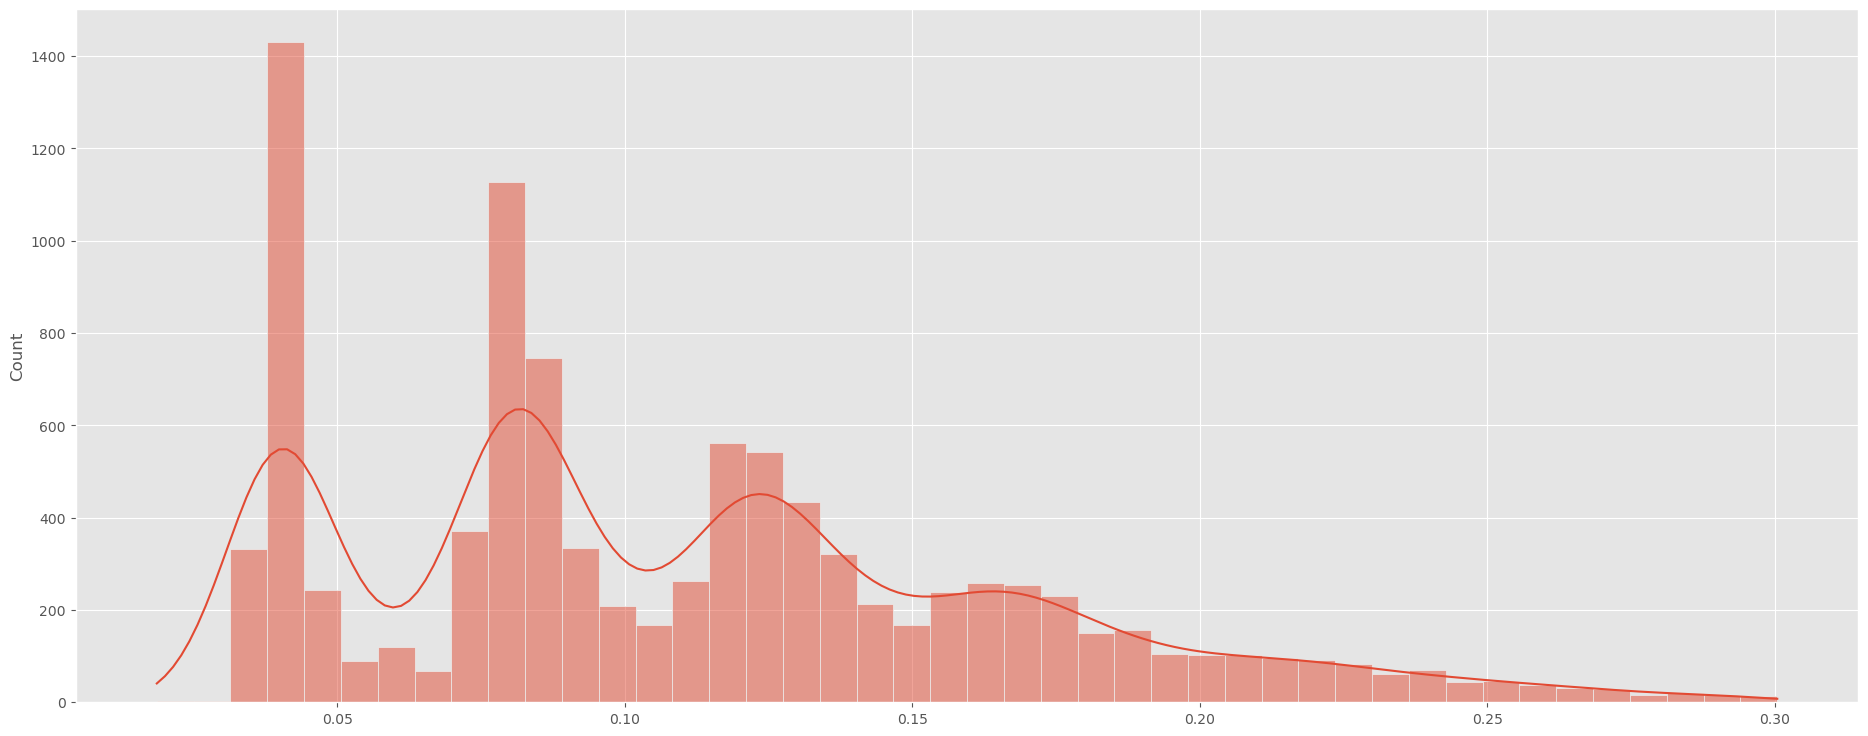

In [278]:
sns.histplot(data=first_exp, kde=True);

In [279]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

In [280]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)

In [282]:
grid_search.fit(first_exp.reshape((-1, 1)));

In [283]:
def grid_search_to_data_frame(grid_search):
    df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
    ]
    df["mean_test_score"] = -df["mean_test_score"]
    df = df.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )
    return df

In [284]:
df = grid_search_to_data_frame(grid_search)
df.sort_values(by="BIC score").head()

Number of components Type of covariance    BIC score
4                     5          spherical -7116.655162
22                    5               full -7116.115217
16                    5               diag -7115.934312
5                     6          spherical -7102.181435
23                    6               full -7101.902621

In [285]:
def graph_grid_search_result(df):
    sns.catplot(
        data=df,
        kind="bar",
        x="Number of components",
        y="BIC score",
        hue="Type of covariance",
    )
    plt.show()

/home/velikiyburyat/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


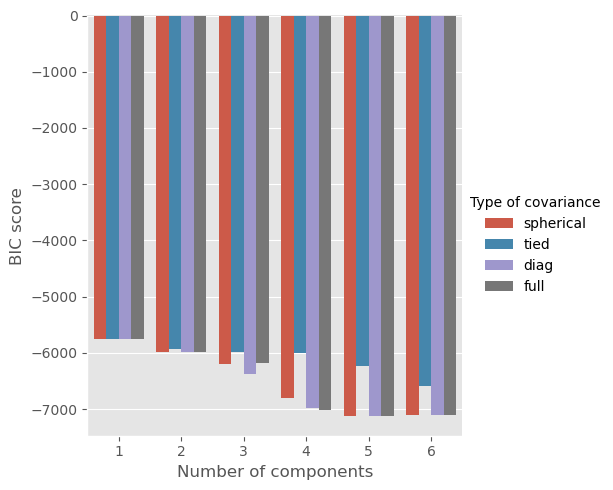

In [286]:
graph_grid_search_result(df)

## Обучим  модель с лучшей метрикой.

In [334]:
np.random.seed(7)
model = GaussianMixture(n_components=grid_search.best_params_["n_components"],\
                        covariance_type=grid_search.best_params_["covariance_type"], init_params="random")
y_pred = model.fit_predict(first_exp.reshape((-1, 1)))
predictions = pd.DataFrame(np.hstack((first_exp.reshape((-1, 1)), y_pred.reshape((-1, 1))))).rename(columns={0: "target", 1: "mixture"})

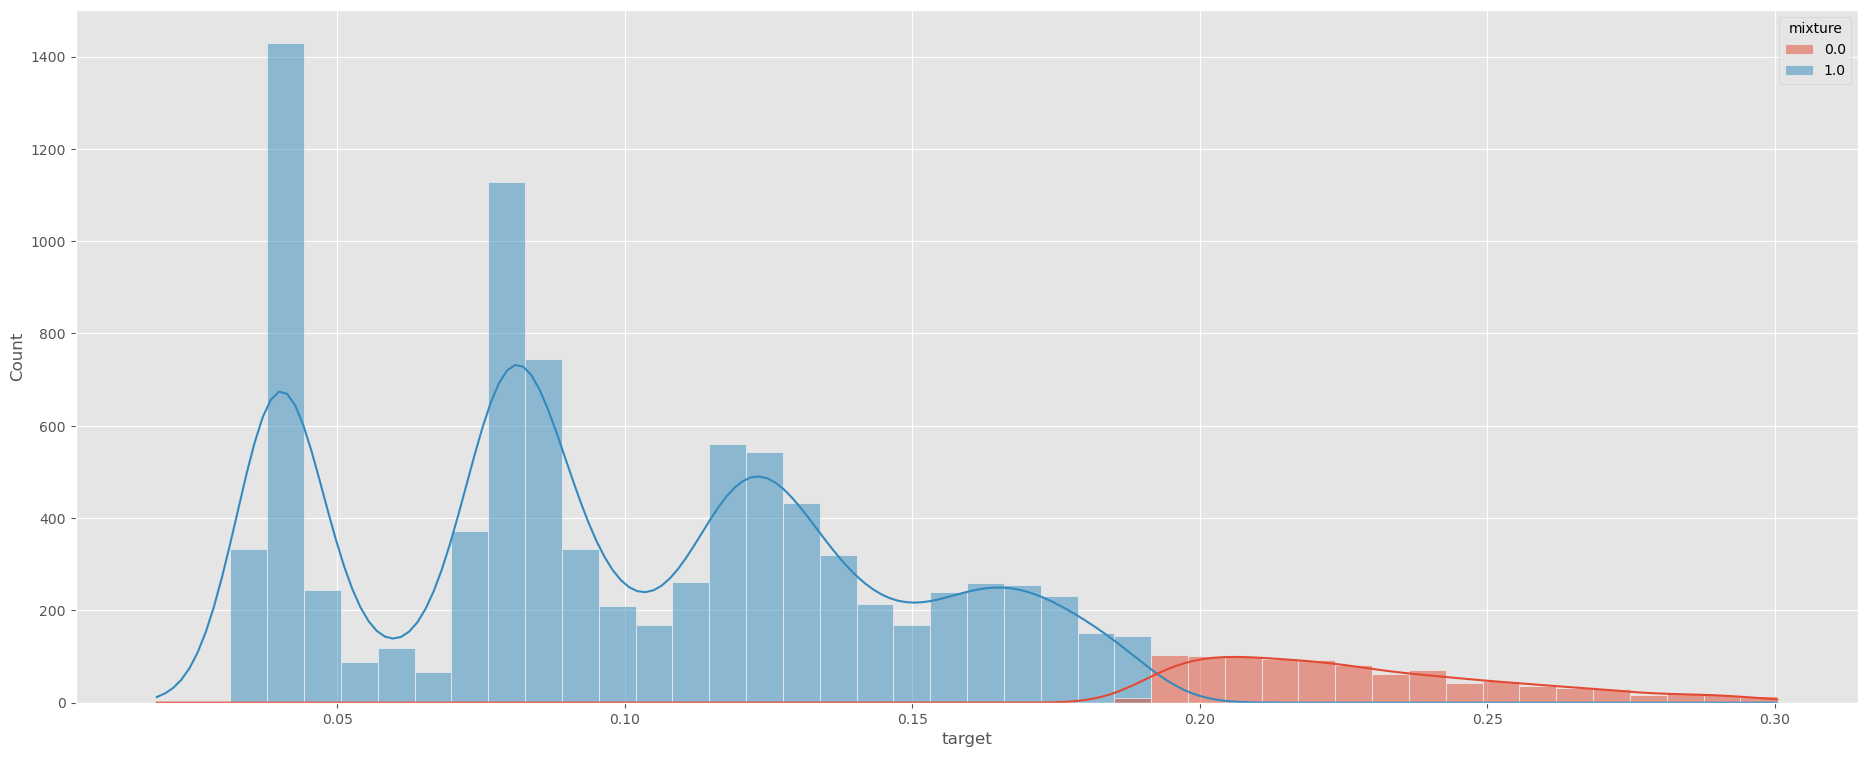

In [335]:
sns.histplot(data=predictions, x = "target", hue = "mixture", pmax=0.5, kde=True);

## Визуализируем среднии и дисперсии по смесям в окнах на 200 наблюдений.

In [336]:
def moving_average_and_variance(predictions):
    i = 0
    w = 200
    mean = np.empty(shape = (np.unique(predictions.mixture).shape[0], 1))
    std = np.empty(shape = (np.unique(predictions.mixture).shape[0], 1))
    while w * (i + 1) < len(first_exp):
        mean = np.append(mean, predictions.iloc[w*i:w*(i+1),:].groupby("mixture").mean().values, axis=1)
        std = np.append(std, predictions.iloc[w*i:w*(i+1),:].groupby("mixture").std().values, axis=1)
        i = i + 1
    return mean[:,1:], std[:,1:]

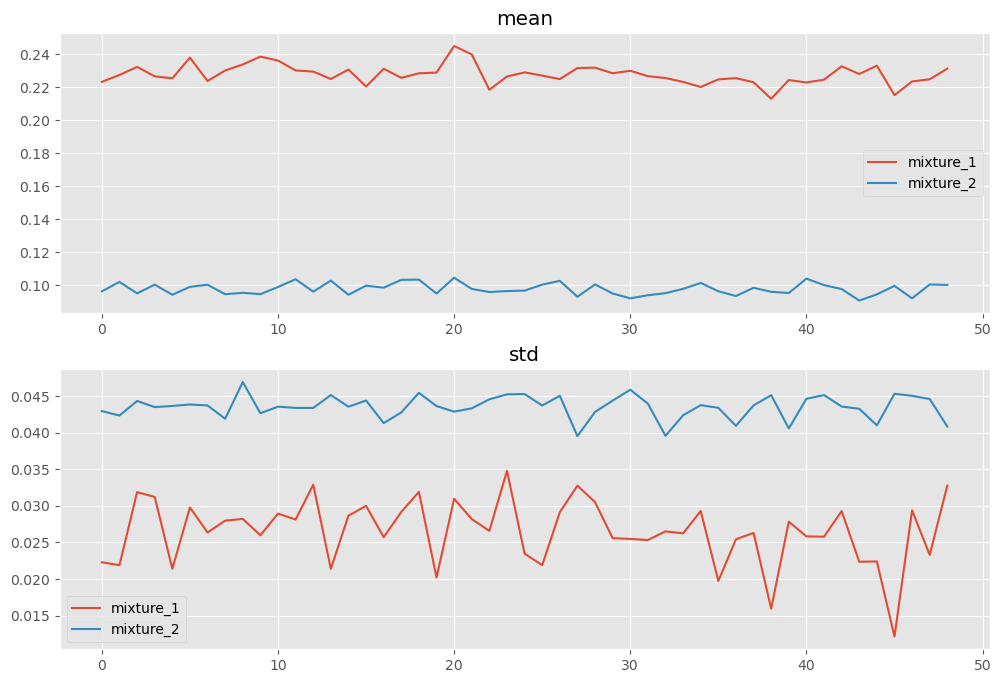

In [338]:
mean, std = moving_average_and_variance(predictions)

f, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(mean.T, label=["mixture_1", "mixture_2"])
axs[1].plot(std.T, label=["mixture_1", "mixture_2"])
axs[0].title.set_text(f"mean")
axs[1].title.set_text(f"std")
axs[0].legend()
axs[1].legend()

## STL декомпозиция. Смотрим на сезонность и тренд.

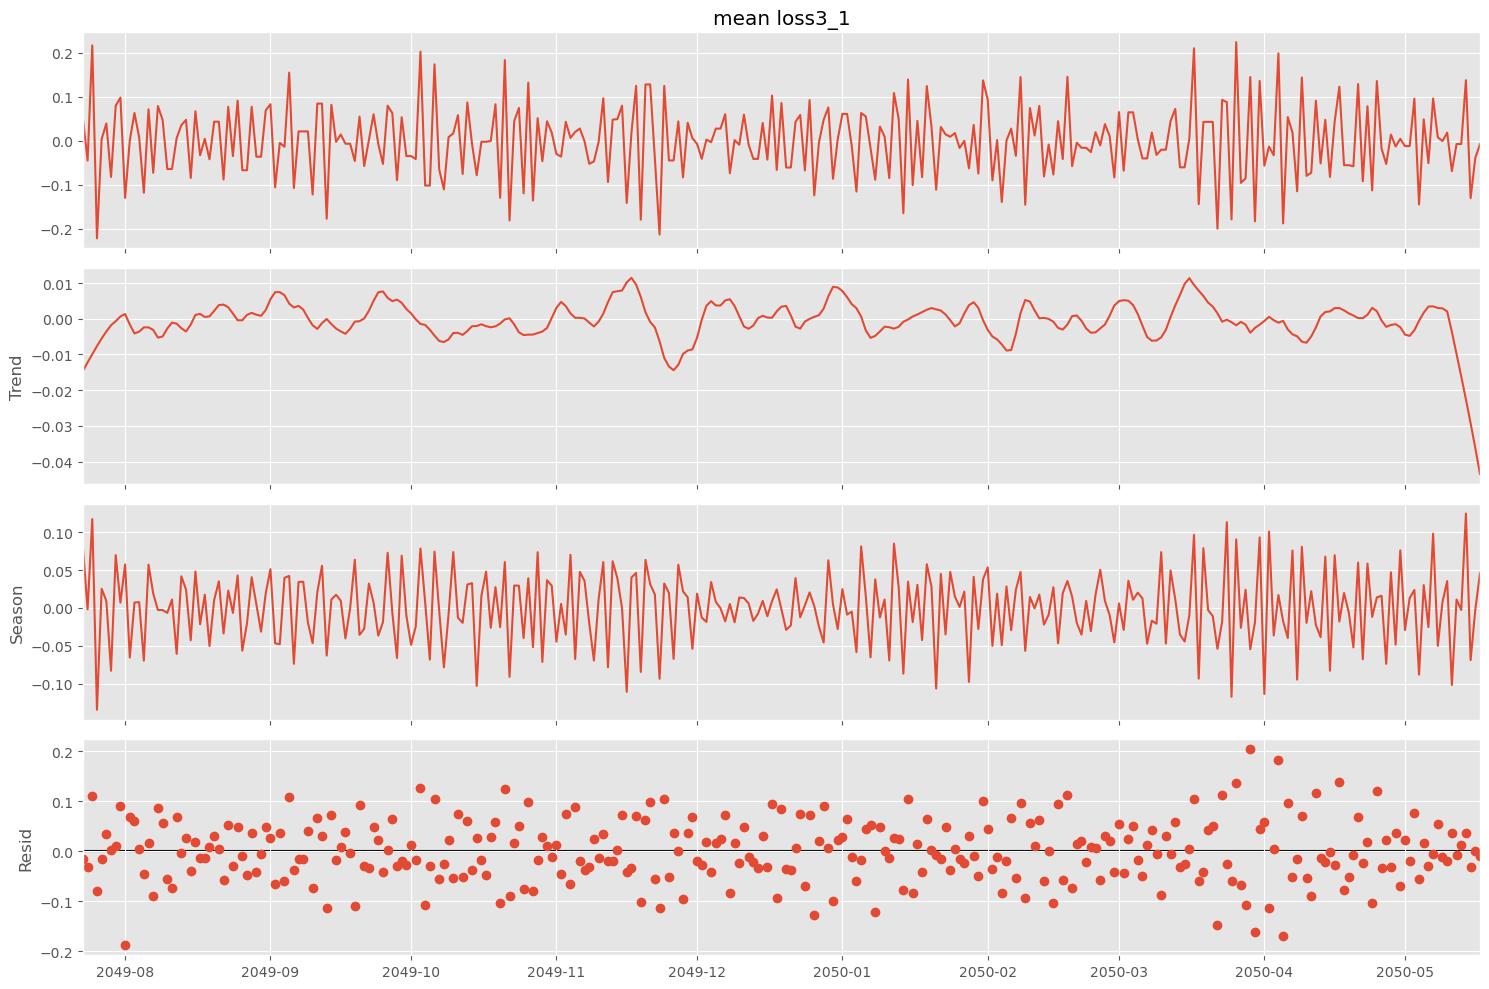

In [339]:
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(time_series_loss_3_smooth.iloc[-300:,0].diff()[1:])
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

## Автокорреляции.

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='mean loss3_1'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

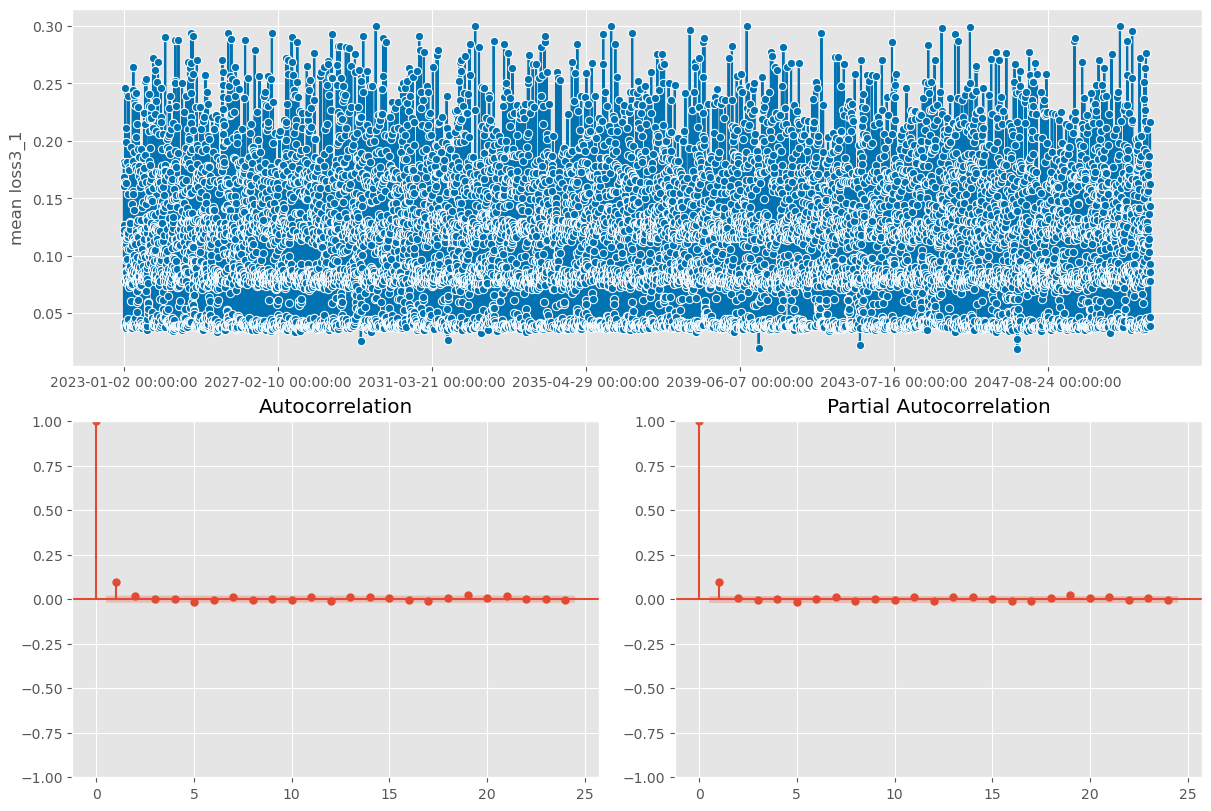

In [340]:
from sktime.utils.plotting import plot_correlations
plot_correlations(time_series_loss_3_smooth.iloc[:,0])

## Проделаем то же самое для 2-го эксперимента.

In [342]:
grid_search.fit(second_exp.reshape((-1, 1)));

In [343]:
df = grid_search_to_data_frame(grid_search)
df.sort_values(by="BIC score").head()

Number of components Type of covariance    BIC score
5                     6          spherical -7146.601814
23                    6               full -7146.537753
17                    6               diag -7146.391663
4                     5          spherical -7131.025822
16                    5               diag -7130.316140

/home/velikiyburyat/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


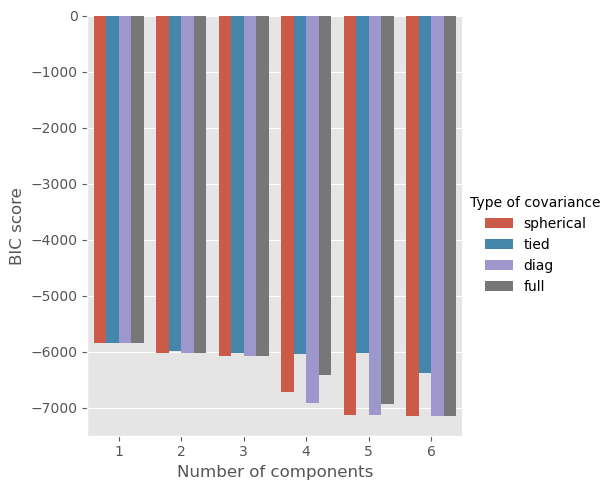

In [344]:
graph_grid_search_result(df)

In [356]:
np.random.seed(3)
model = GaussianMixture(n_components=grid_search.best_params_["n_components"],\
                        covariance_type=grid_search.best_params_["covariance_type"], init_params="random")
y_pred = model.fit_predict(second_exp.reshape((-1, 1)))
predictions = pd.DataFrame(np.hstack((second_exp.reshape((-1, 1)), y_pred.reshape((-1, 1))))).rename(columns={0: "target", 1: "mixture"})

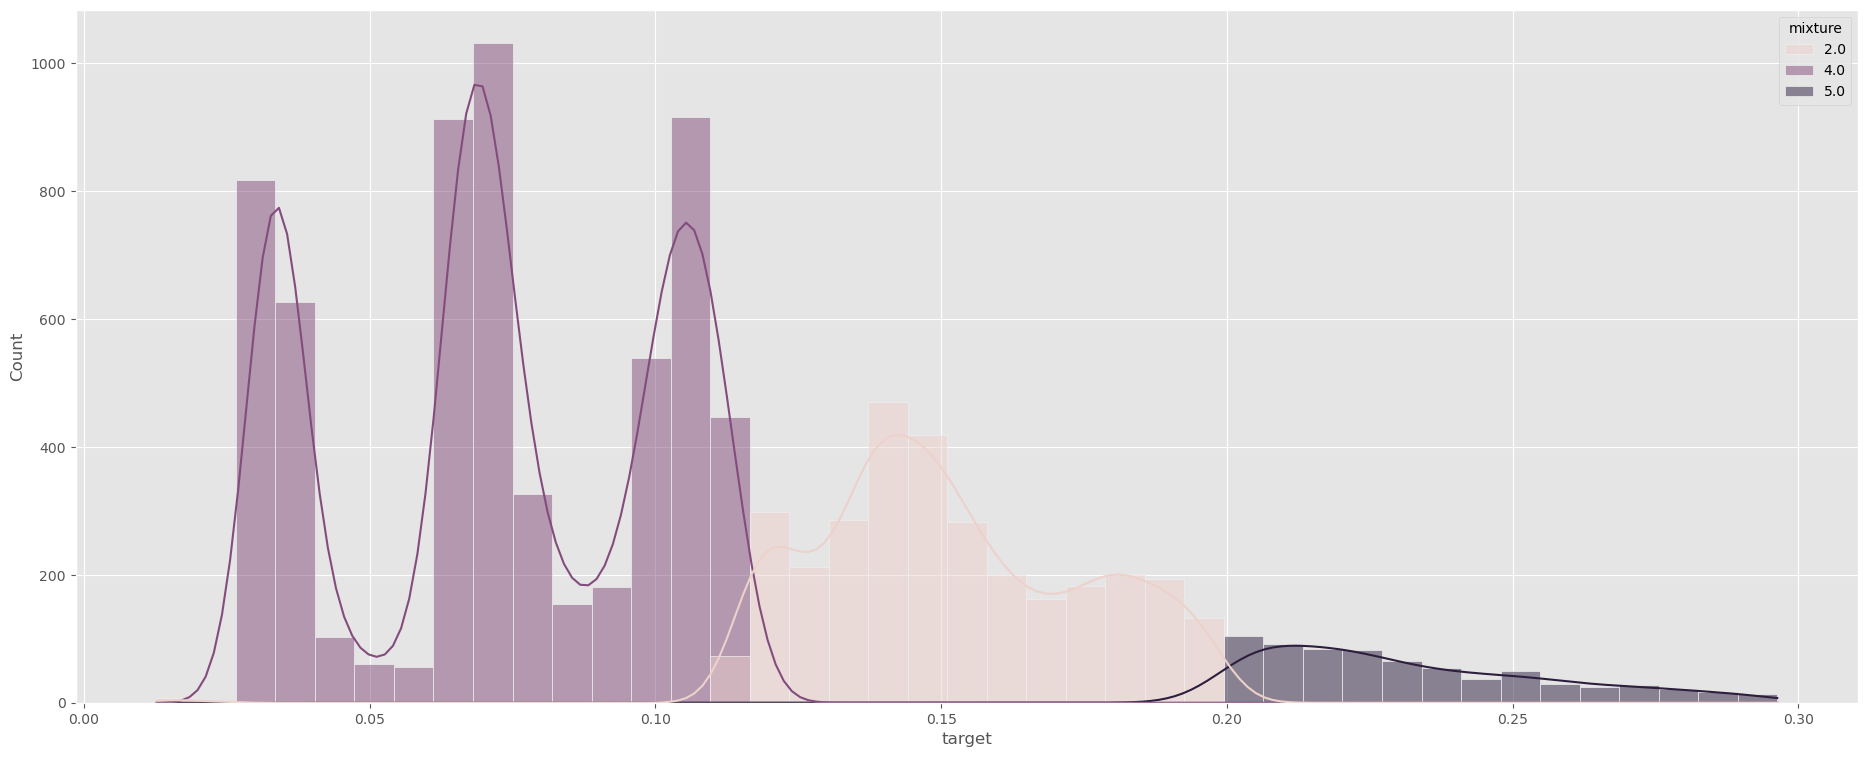

In [357]:
sns.histplot(data=predictions, x = "target", hue = "mixture", pmax=0.5, kde=True);

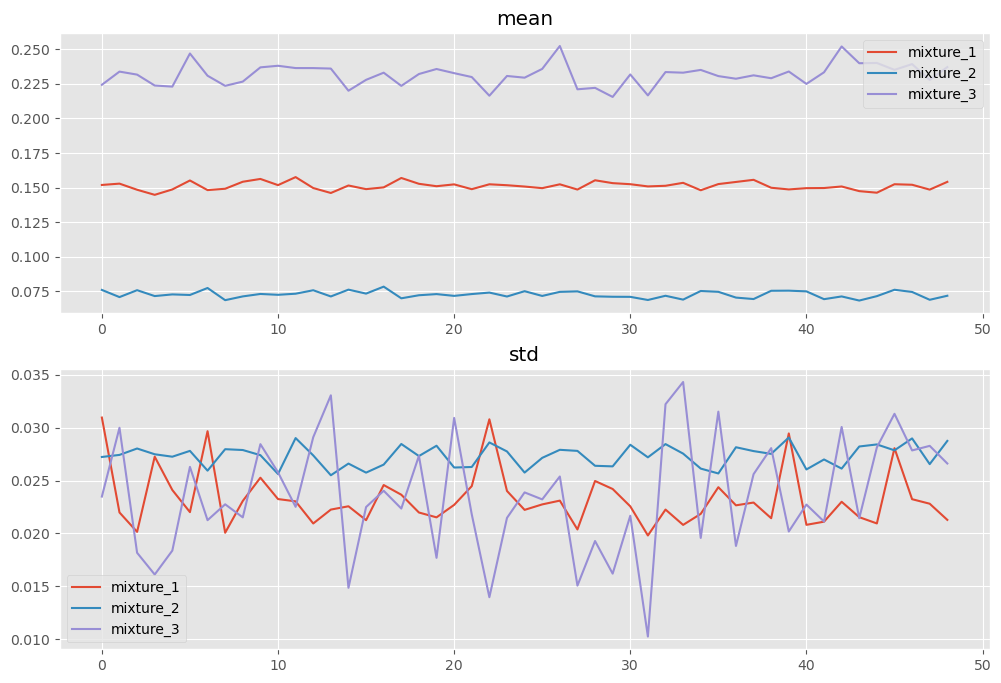

In [358]:
mean, std = moving_average_and_variance(predictions)

f, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(mean.T, label=["mixture_1", "mixture_2", "mixture_3"])
axs[1].plot(std.T, label=["mixture_1", "mixture_2", "mixture_3"])
axs[0].title.set_text(f"mean")
axs[1].title.set_text(f"std")
axs[0].legend()
axs[1].legend()

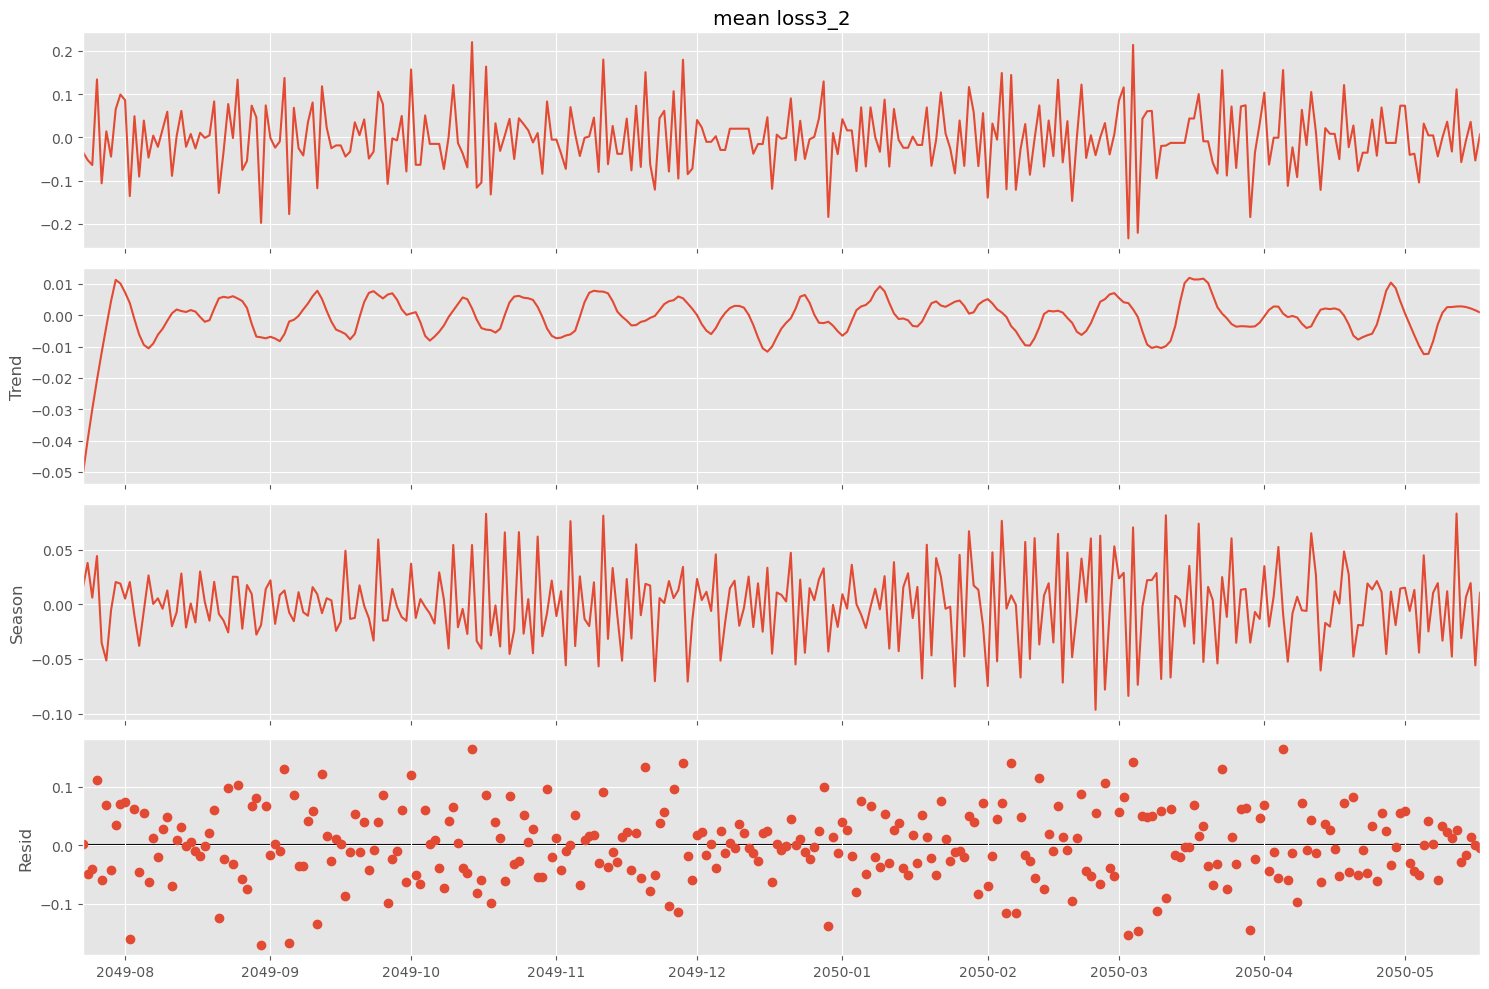

In [440]:
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(time_series_loss_3_smooth.iloc[-300:,1].diff()[1:])
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='mean loss3_3'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

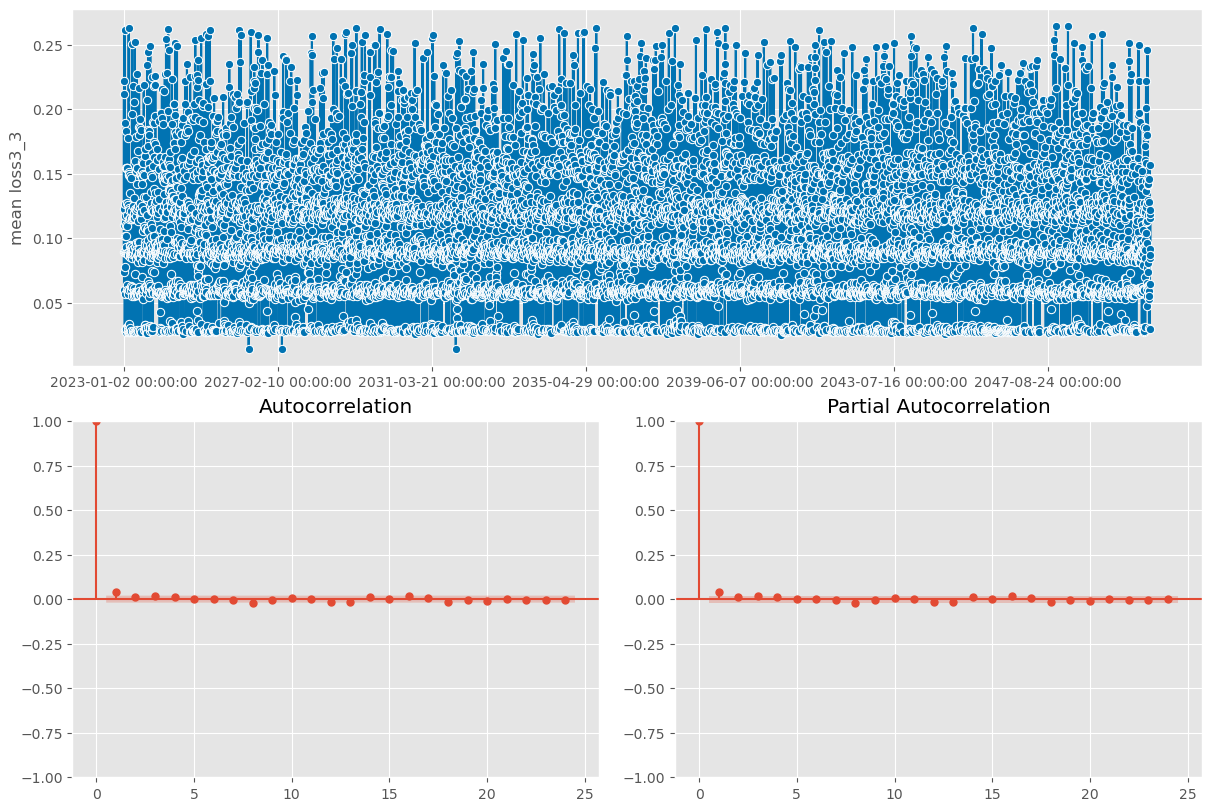

In [442]:
plot_correlations(time_series_loss_3_smooth.iloc[:,2])

## Проделаем то же самое для 3-го эксперимента.

In [359]:
grid_search.fit(third_exp.reshape((-1, 1)));

In [360]:
df = grid_search_to_data_frame(grid_search)
df.sort_values(by="BIC score").head()

Number of components Type of covariance    BIC score
17                    6               diag -7808.829415
23                    6               full -7808.168010
5                     6          spherical -7631.176941
16                    5               diag -7386.705185
4                     5          spherical -7018.706693

/home/velikiyburyat/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


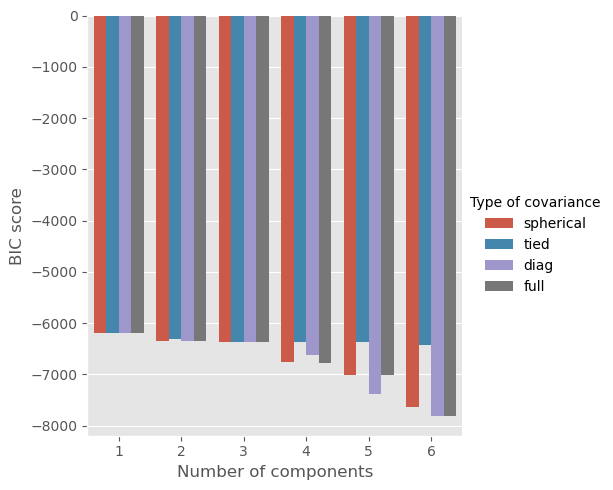

In [361]:
graph_grid_search_result(df)

In [363]:
np.random.seed(8)
model = GaussianMixture(n_components=grid_search.best_params_["n_components"],\
                        covariance_type=grid_search.best_params_["covariance_type"], init_params="random")
y_pred = model.fit_predict(third_exp.reshape((-1, 1)))
predictions = pd.DataFrame(np.hstack((third_exp.reshape((-1, 1)), y_pred.reshape((-1, 1))))).rename(columns={0: "target", 1: "mixture"})

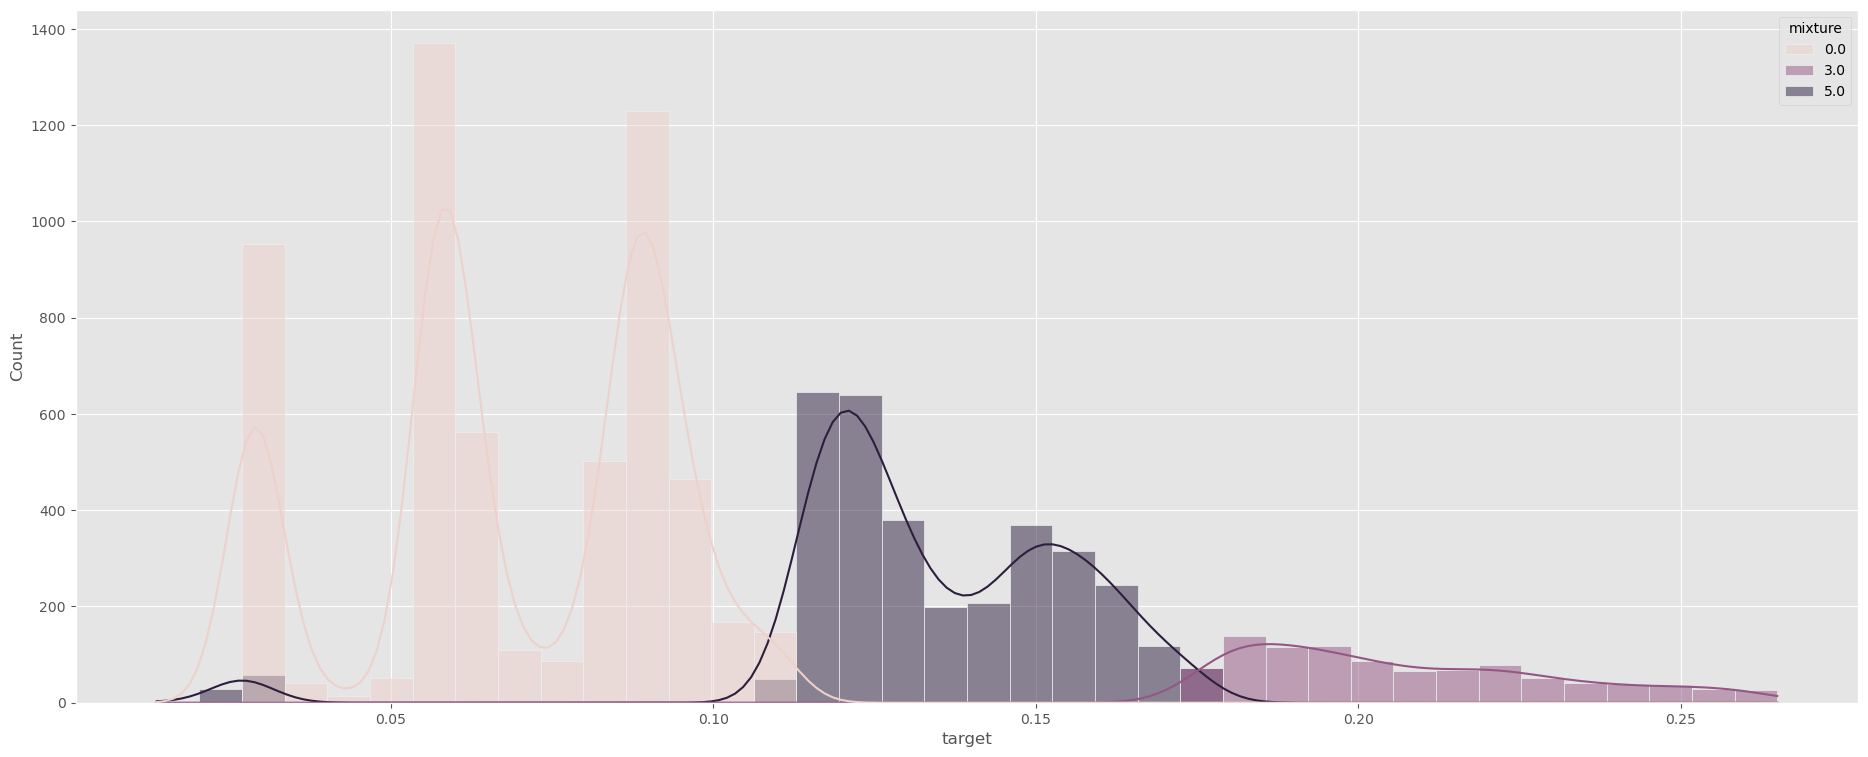

In [364]:
sns.histplot(data=predictions, x = "target", hue = "mixture", pmax=0.5, kde=True);

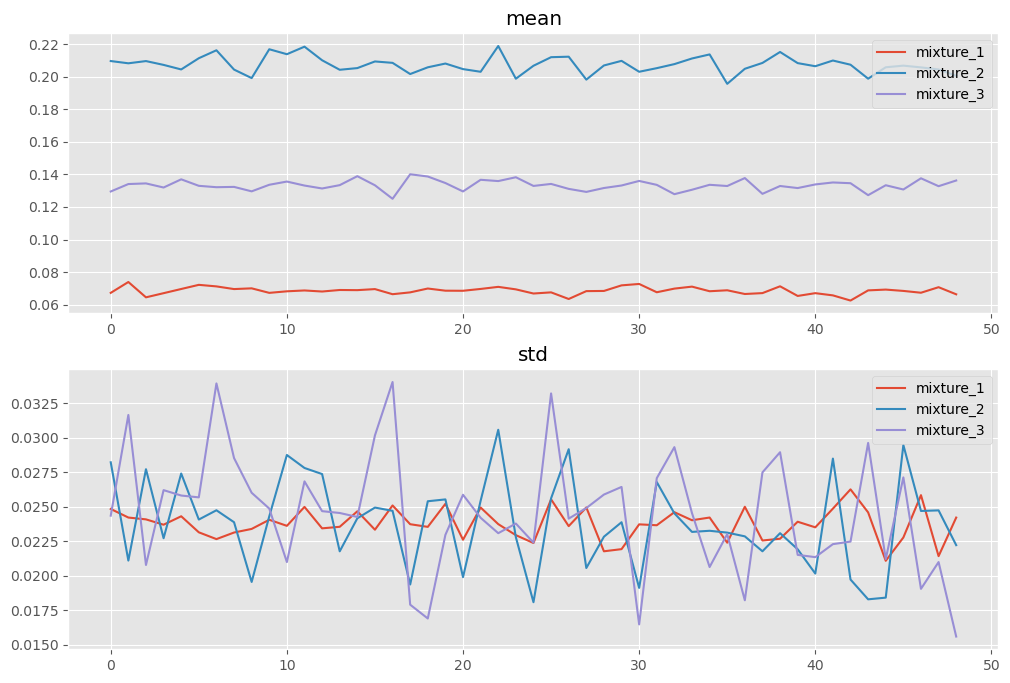

In [365]:
mean, std = moving_average_and_variance(predictions)

f, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(mean.T, label=["mixture_1", "mixture_2", "mixture_3"])
axs[1].plot(std.T, label=["mixture_1", "mixture_2", "mixture_3"])
axs[0].title.set_text(f"mean")
axs[1].title.set_text(f"std")
axs[0].legend()
axs[1].legend()

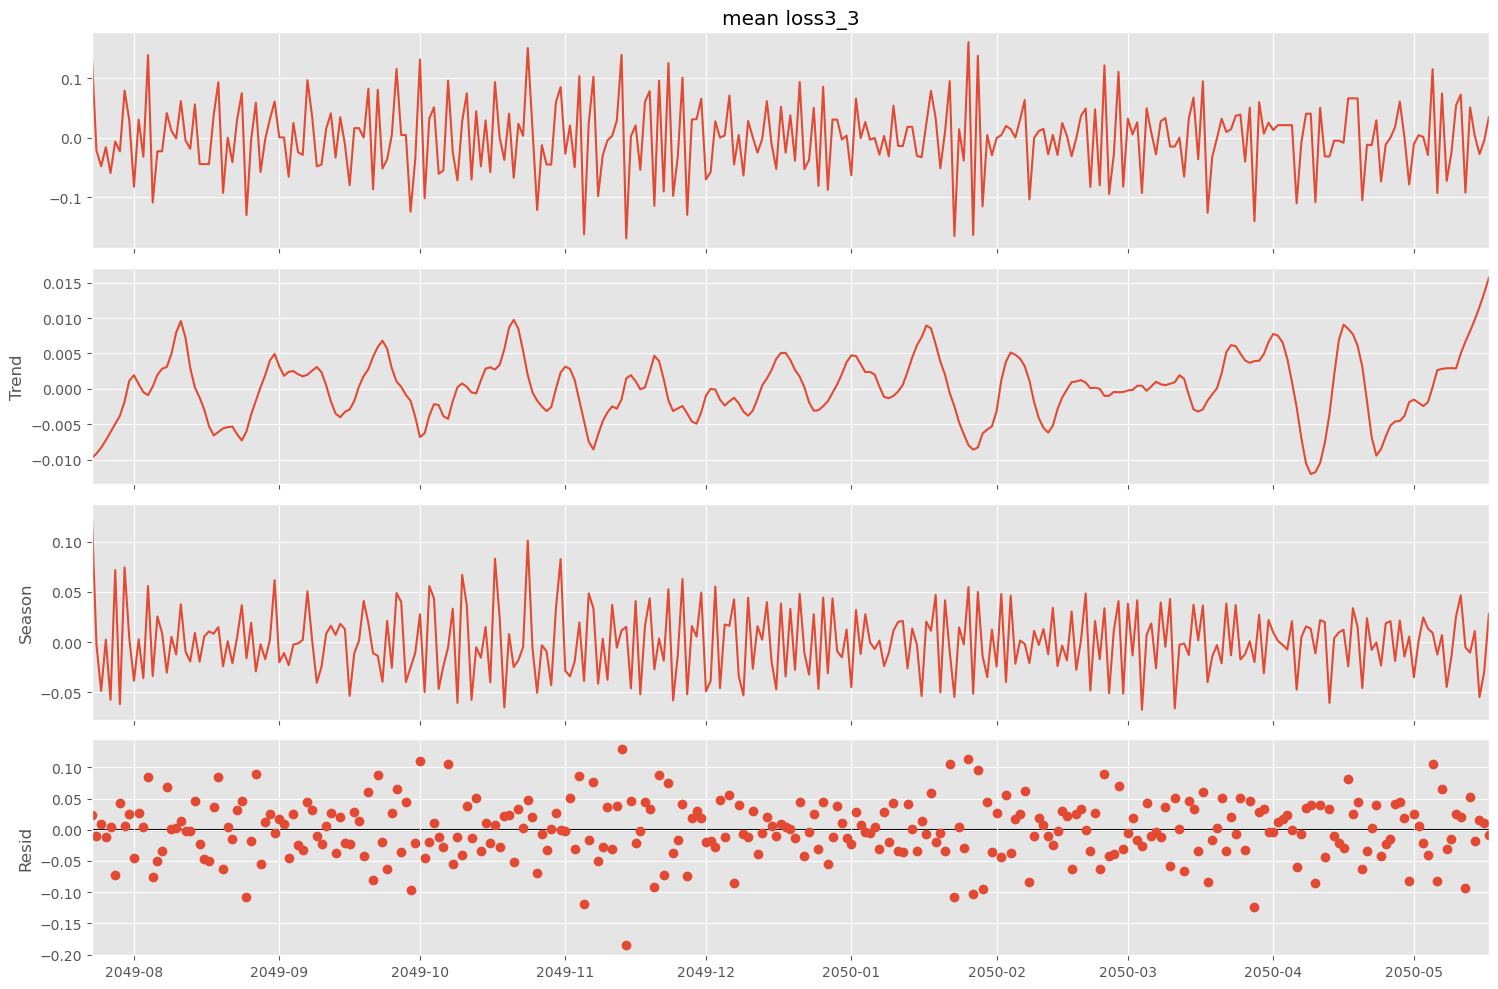

In [441]:
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(time_series_loss_3_smooth.iloc[-300:,2].diff()[1:])
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='mean loss3_3'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

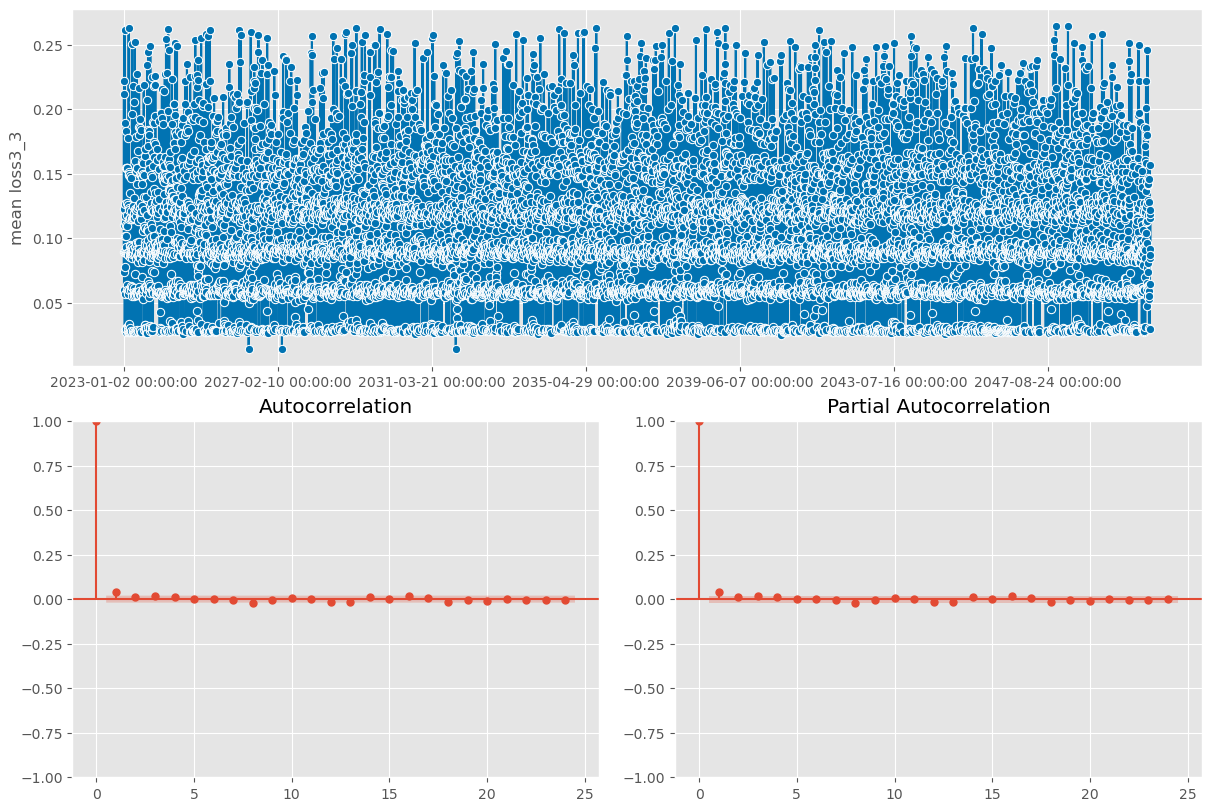

In [443]:
plot_correlations(time_series_loss_3_smooth.iloc[:,2])

## LSTM

## Возьмём первый экcперимент. И предскажем приращение этого ряда.

In [403]:
timeseries = np.array(time_series_loss_3_smooth.iloc[:, 0].diff()[1:].values).reshape((-1, 1))

## Разделим выборку на train и test.

In [421]:
# train-test split for time series
train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

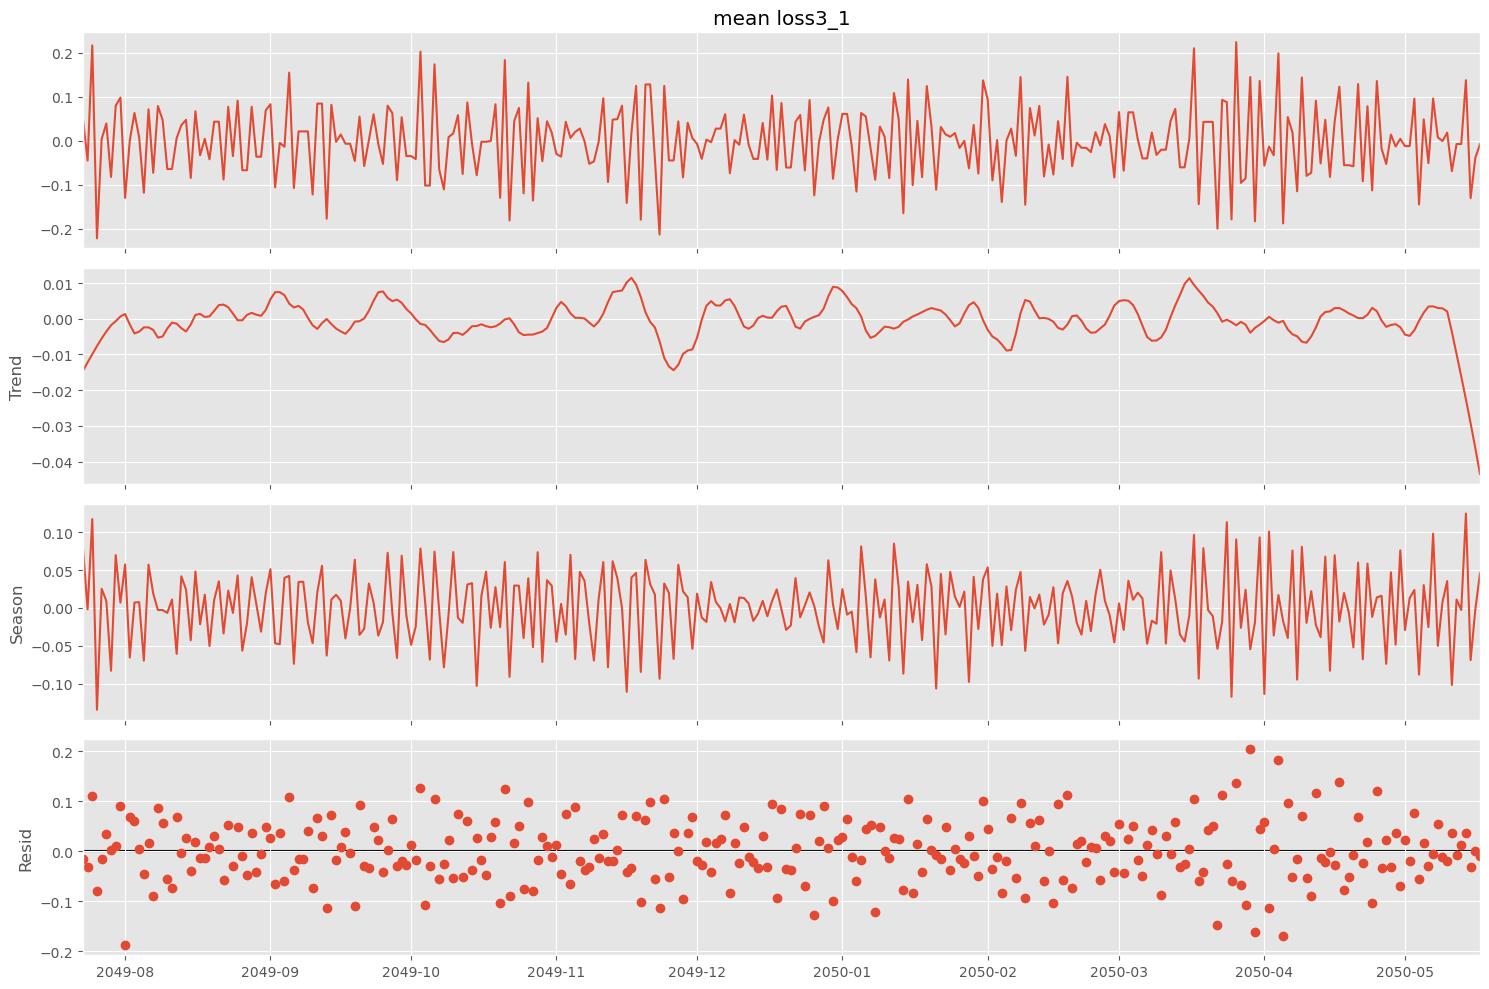

In [422]:
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(time_series_loss_3_smooth.iloc[-300:, 0].diff()[1:])
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='mean loss3_1'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

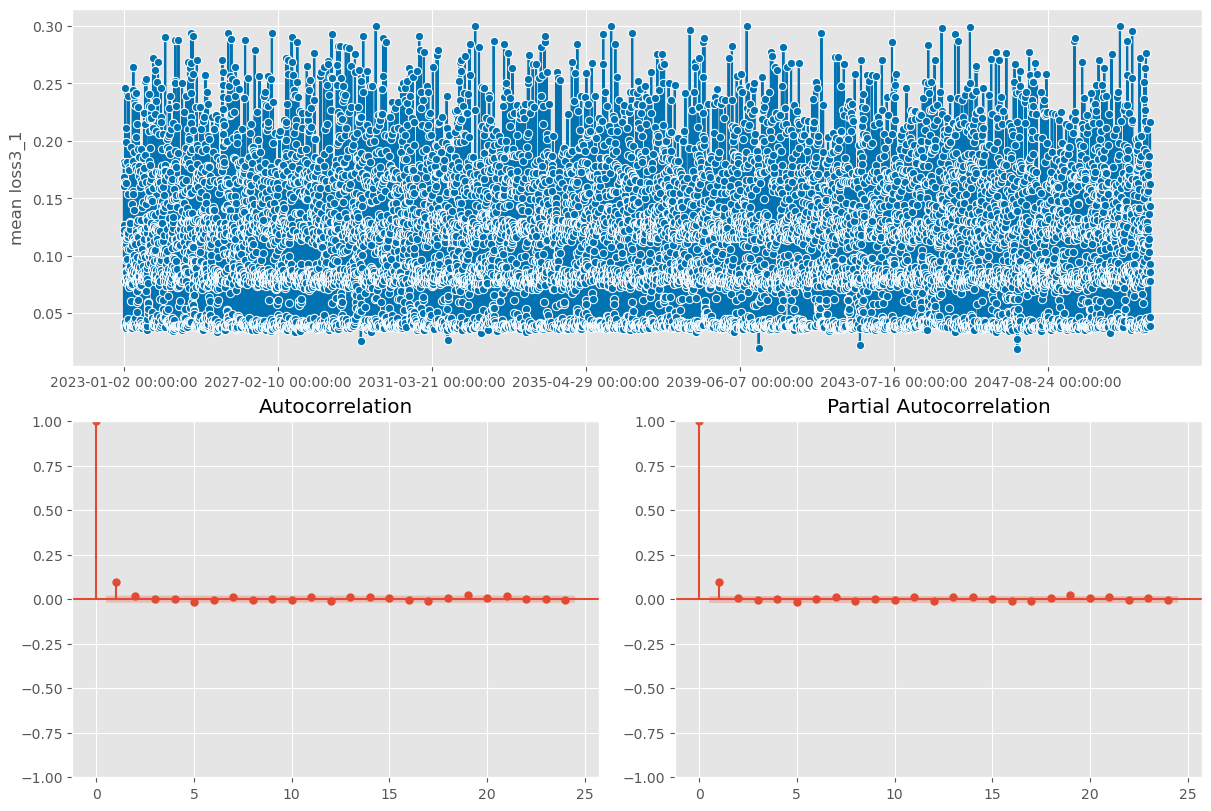

In [423]:
plot_correlations(time_series_loss_3_smooth.iloc[:,0])

## Автокорреляций практически нет. Это хорошо)

In [424]:
import torch
 
def create_dataset(dataset, lookback, steps_to_predict):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback-steps_to_predict+1):
        feature = dataset[i:i+lookback]
        target = dataset[i+steps_to_predict:i+lookback+steps_to_predict]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [436]:
lookback = 100
steps_to_predict = 1
X_train, y_train = create_dataset(train, lookback, steps_to_predict)
X_test, y_test = create_dataset(test, lookback, steps_to_predict)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6897, 100, 1]) torch.Size([6897, 100, 1])
torch.Size([2900, 100, 1]) torch.Size([2900, 100, 1])


In [437]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [438]:
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0594, test RMSE 0.0589
Epoch 1: train RMSE 0.0585, test RMSE 0.0579
Epoch 2: train RMSE 0.0591, test RMSE 0.0587
Epoch 3: train RMSE 0.0581, test RMSE 0.0577
Epoch 4: train RMSE 0.0584, test RMSE 0.0579
Epoch 5: train RMSE 0.0584, test RMSE 0.0579
Epoch 6: train RMSE 0.0585, test RMSE 0.0581
Epoch 7: train RMSE 0.0594, test RMSE 0.0590
Epoch 8: train RMSE 0.0581, test RMSE 0.0576
Epoch 9: train RMSE 0.0592, test RMSE 0.0589


## Значение метрик выше. Ниже график предсказания на последних 100 шагах теста.

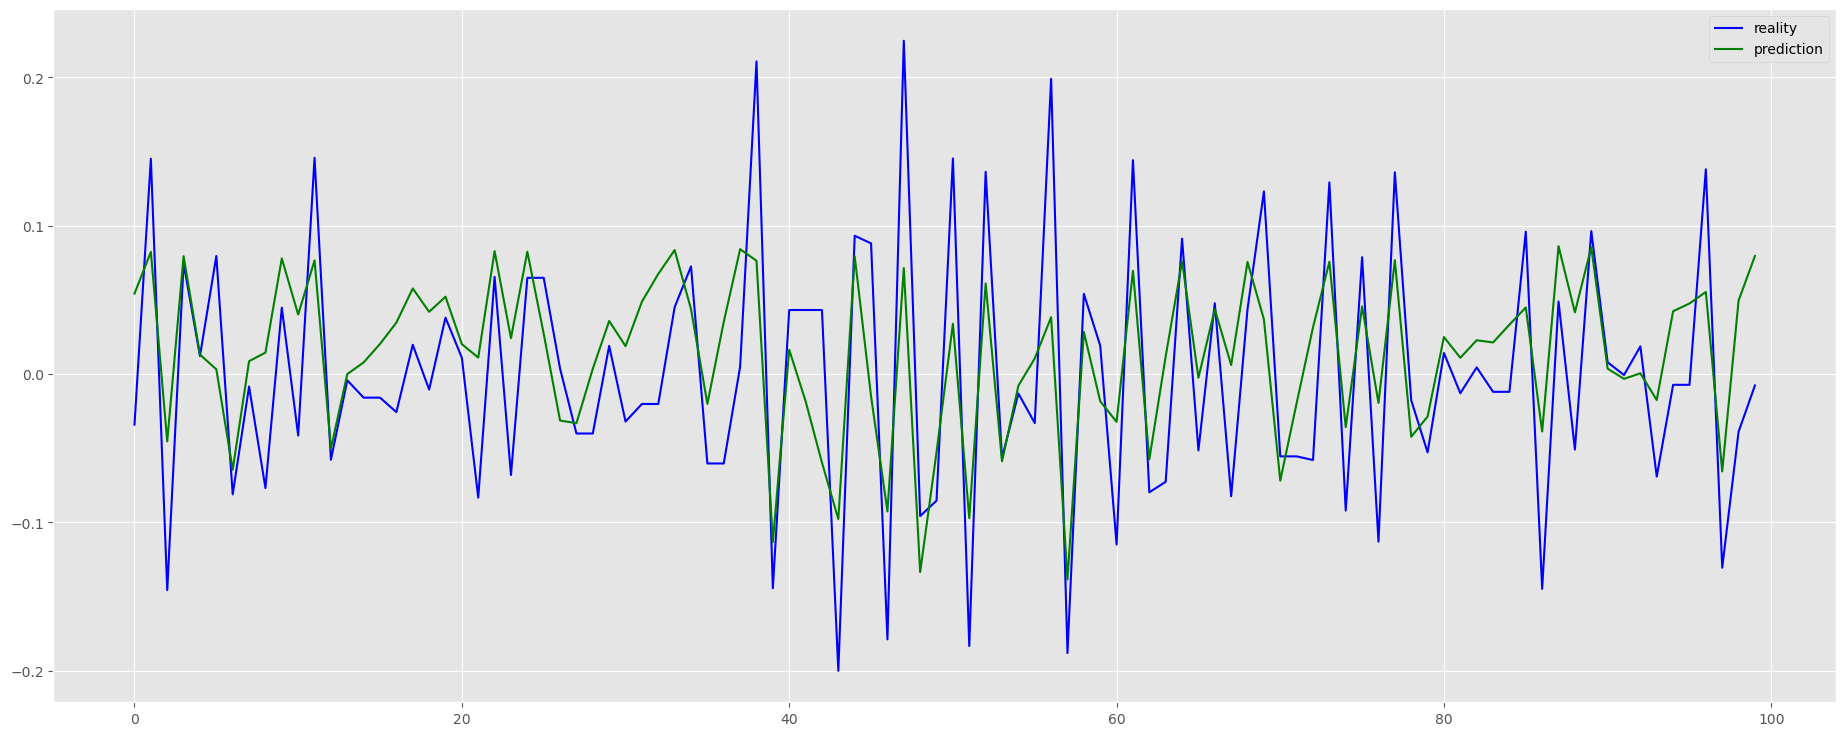

In [445]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = y_pred
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(first_exp.reshape((-1, 1)))] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries[-100:], c='b', label = "reality")
#plt.plot(train_plot, c='r')
plt.plot(test_plot[-100:], c='g', label = "prediction")
plt.legend()
plt.show()